Adding monotonicity constraints to clean interactions and effects

**Table of contents**<a id='toc0_'></a>    
- [Process inputs](#toc1_)    
- [Read and Prep data](#toc2_)    
- [Create models](#toc3_)    
  - [Train model limiting no interaction](#toc3_1_)    
    - [Predict and evaluate](#toc3_1_1_)    
  - [Train model 2nd layer to just find 2 way interactions](#toc3_2_)    
    - [Evaluate](#toc3_2_1_)    
  - [Train 3 model and evaluate](#toc3_3_)    
- [Feature importance](#toc4_)    
  - [Feature importance main effects](#toc4_1_)    
  - [Feature importance 2 way interactions](#toc4_2_)    
  - [Feature importance 3 way interactions](#toc4_3_)    
- [Model Iterrogation](#toc5_)    
  - [Calc shap values](#toc5_1_)    
- [Contribution plots](#toc6_)    
- [Interaction analysis](#toc7_)    
  - [Main interactions](#toc7_1_)    
  - [Interaction plots](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [82]:
import pandas as pd
import lightgbm as lgb
from func import calculate_prediction_quality, calculate_ranking_metrics, get_feature_importance

# <a id='toc1_'></a>[Process inputs](#toc0_)

In [83]:
target = 'qualidade_global_media_dada_pela_equipe_'
categorical_features = ['laboratorio', 'fora_de_tipo_x_tipo_unico']
data_path = "../data/processed/df_model.parquet"

# <a id='toc2_'></a>[Read and Prep data](#toc0_)

In [84]:
data = pd.read_parquet(data_path)

# Turn categorical variables to categorical type for lightgbm split variables as categorical
for cat_var in categorical_features:
    data[cat_var] = pd.Categorical(data[cat_var])

# Isolate and remove response column from data
response = data[target].values
trn_data = data.drop(columns=[target])

predictors = trn_data.columns
# Create lgbm dataset
trn_dset = lgb.Dataset(trn_data, label=response, params={'max_bin': 5000})

# <a id='toc3_'></a>[Create models](#toc0_)

## <a id='toc3_1_'></a>[Train model limiting no interaction](#toc0_)

In [85]:
predictors

Index(['laboratorio', 'fora_de_tipo_x_tipo_unico', 'odor_do_po', '_docura',
       '_corpo', '_acidez_intensidade', '_acidez_qualidade', '_amargor',
       '_adstringencia', '_intensidade', '_alcoolico_',
       '_cedro_carvalho_amadeirado_', '_amendoado_castanhas_',
       '_animalico_curral_', '_azedo_', '_baunilha_', '_borracha_',
       '_caramelizado_caramelo_doce_', '_cereal_', '_chocolate_cacau_',
       '_cozido_assado_', '_especiarias_', '_fermentado_', '_floral_',
       '_frutado_', '_iodoformio_quimico_', '_madeira_papelao_', '_mel_',
       '_queimado_defumado_', '_terroso_mofo_', '_tostado_', '_vegetal_',
       '_velho_oxidado_', '_verde_herbaceo_'],
      dtype='object')

In [105]:
mono_dict = {"_acidez_qualidade":1, 
            "_docura":1, 
            "_acidez_intensidade":-1,
            "_amargor":-1,
            "_intensidade":-1,
            "_adstringencia":-1,
            "odor_do_po":-1,
            "_corpo":1,
            "_frutado_":1,
            "_tostado_":-1,
            "_mel_":1,
            "_madeira_papelao_":1,
            "_chocolate_cacau_":1,
            "_velho_oxidado_":-1,
            "_terroso_mofo_":-1,
            "_cereal_":1,
            "_caramelizado_caramelo_doce_":1,
            "_baunilha_":1,
            "_iodoformio_quimico_":-1,
            "_borracha_":-1,
            "_azedo_":-1,
            "_cedro_carvalho_amadeirado_":1,
            "_floral_":1,
            "_queimado_defumado_":1,
            "_amendoado_castanhas_":1}
mono_list = [mono_dict[p] if p in mono_dict else 0 for p in predictors]

In [106]:


mdl = lgb.train(params={"objective":"regression", 
                        "num_boost_round":10000, 
                        "max_depth":1, 
                        "learning_rate":.05,
                        'max_bin': 5000,
                        "verbose":-1,
                        "monotone_constraints":mono_list
                        }, train_set=trn_dset)

Found `num_boost_round` in params. Will use it instead of argument


### <a id='toc3_1_1_'></a>[Predict and evaluate](#toc0_)

In [107]:
prd = mdl.predict(trn_data)
calculate_prediction_quality(list(response),list(prd))

{'rmse': 0.1616858077861515,
 'mae': 0.10208310189408816,
 'r2': 0.9833590652781272,
 'gini': 0.12100289884514748}

## <a id='toc3_2_'></a>[Train model 2nd layer to just find 2 way interactions](#toc0_)

In [108]:
int_dset = lgb.Dataset(trn_data, label=response, init_score=prd)

int_mdl = lgb.train(params={"objective":"regression",
                            "num_boost_round":10000, 
                            "max_depth":2, 
                            "learning_rate":1, 
                            "extra_trees" :True,
                            "verbose":-1}, 
                            train_set=int_dset)

Found `num_boost_round` in params. Will use it instead of argument


### <a id='toc3_2_1_'></a>[Evaluate](#toc0_)

In [109]:
int_prd = int_mdl.predict(trn_data) + prd
calculate_prediction_quality(list(response),list(int_prd))

{'rmse': 0.0010214368094442806,
 'mae': 0.0005919170121942527,
 'r2': 0.9999993358641495,
 'gini': 0.12220892887011103}

## <a id='toc3_3_'></a>[Train 3 model and evaluate](#toc0_)

In [110]:
int3_dset = lgb.Dataset(trn_data, label=response, init_score=int_prd)

int3_mdl = lgb.train(params={"objective":"regression", 
                            "num_boost_round":10000, 
                            "max_depth":3, 
                            "learning_rate":1, 
                            "extra_trees" :True,
                            "verbose":-1}, 
                            train_set=int3_dset)

Found `num_boost_round` in params. Will use it instead of argument


In [111]:
int3_prd = int3_mdl.predict(trn_data) + int_prd
calculate_prediction_quality(list(response),list(int3_prd))

{'rmse': 4.800665641792258e-07,
 'mae': 2.709420720695691e-07,
 'r2': 0.9999999999998533,
 'gini': 0.12220892887011103}

In [112]:
calculate_ranking_metrics(list(response),list(int3_prd))

{'spearman_correlation': 0.9972224453848217,
 'kendall_tau': 0.9735444683703425,
 'ranking_error': 0.026559421857934654,
 'ordering_accuracy': 0.949229392971246}

# <a id='toc4_'></a>[Feature importance](#toc0_)
## <a id='toc4_1_'></a>[Feature importance main effects](#toc0_)

In [113]:
main_imp = get_feature_importance(mdl,trn_data.columns)
main_imp

gain
Feature                           
_acidez_intensidade           3528
_corpo                        1539
_acidez_qualidade             1353
odor_do_po                     501
_docura                        500
_intensidade                   379
_madeira_papelao_              306
_frutado_                      293
_amargor                       290
fora_de_tipo_x_tipo_unico      191
_queimado_defumado_            145
_chocolate_cacau_              130
_terroso_mofo_                  90
_amendoado_castanhas_           88
laboratorio                     85
_verde_herbaceo_                72
_borracha_                      69
_cereal_                        69
_caramelizado_caramelo_doce_    61
_baunilha_                      58
_velho_oxidado_                 56
_tostado_                       48
_mel_                           39
_adstringencia                  36
_floral_                        29
_cedro_carvalho_amadeirado_     25
_azedo_                         12
_iodoformio_quimico_             8
_alcoolico_                      0
_animalico_curral_               0
_fermentado_                     0
_especiarias_                    0
_cozido_assado_                  0
_vegetal_                        0

## <a id='toc4_2_'></a>[Feature importance 2 way interactions](#toc0_)

In [114]:
int_imp = get_feature_importance(int_mdl,trn_data.columns)
int_imp

gain
Feature                           
odor_do_po                    2167
_intensidade                  1959
_amargor                      1667
_chocolate_cacau_             1623
_corpo                        1604
_velho_oxidado_               1561
_acidez_intensidade           1472
_queimado_defumado_           1401
_adstringencia                1396
_docura                       1339
_acidez_qualidade             1321
_madeira_papelao_             1273
_tostado_                     1154
fora_de_tipo_x_tipo_unico      887
laboratorio                    825
_caramelizado_caramelo_doce_   745
_terroso_mofo_                 699
_verde_herbaceo_               694
_frutado_                      644
_iodoformio_quimico_           577
_borracha_                     479
_mel_                          472
_amendoado_castanhas_          460
_cedro_carvalho_amadeirado_    458
_cereal_                       375
_floral_                       301
_baunilha_                     119
_azedo_                         80
_alcoolico_                      0
_animalico_curral_               0
_fermentado_                     0
_especiarias_                    0
_cozido_assado_                  0
_vegetal_                        0

## <a id='toc4_3_'></a>[Feature importance 3 way interactions](#toc0_)

In [115]:
get_feature_importance(int3_mdl,trn_data.columns)

gain
Feature                           
_chocolate_cacau_             4241
_velho_oxidado_               4036
_madeira_papelao_             4003
odor_do_po                    3819
_queimado_defumado_           3675
_intensidade                  3233
_tostado_                     2572
_acidez_intensidade           2546
_adstringencia                2379
_amargor                      2337
_corpo                        2252
_acidez_qualidade             2163
_docura                       2137
fora_de_tipo_x_tipo_unico     1777
laboratorio                   1721
_caramelizado_caramelo_doce_  1345
_frutado_                     1259
_iodoformio_quimico_          1056
_borracha_                     999
_verde_herbaceo_               982
_terroso_mofo_                 944
_mel_                          914
_amendoado_castanhas_          687
_cedro_carvalho_amadeirado_    572
_cereal_                       322
_floral_                       317
_baunilha_                     128
_azedo_                        111
_alcoolico_                      0
_animalico_curral_               0
_fermentado_                     0
_especiarias_                    0
_cozido_assado_                  0
_vegetal_                        0

# <a id='toc5_'></a>[Model Iterrogation](#toc0_)

## <a id='toc5_1_'></a>[Calc shap values](#toc0_)

In [116]:
from shap import TreeExplainer

exp = TreeExplainer(mdl)
shap = exp.shap_values(trn_data)

shap_df = pd.DataFrame(shap, columns=trn_data.columns)
shap_df

laboratorio  fora_de_tipo_x_tipo_unico  odor_do_po   _docura    _corpo  \
0       0.013122                  -0.306235    0.219427 -0.517697 -0.257125   
1       0.013122                  -0.306235    0.181582 -0.201697 -0.231242   
2       0.013122                   0.033063    0.210160 -0.517697 -0.257125   
3       0.013122                   0.033063    0.181582 -0.201697 -0.158557   
4       0.013122                   0.033063    0.181582  0.042513  0.241595   
..           ...                        ...         ...       ...       ...   
621     0.013122                   0.033063   -0.034033 -0.133772 -0.140600   
622     0.013122                   0.033063   -0.034033 -0.173040 -0.196109   
623     0.013122                   0.033063   -0.034033 -0.173040 -0.196109   
624     0.013122                   0.033063   -0.034033 -0.133772 -0.140600   
625     0.013122                   0.033063   -0.034033 -0.173040 -0.158557   

     _acidez_intensidade  _acidez_qualidade  _amargor  _adstringencia  \
0               0.386775          -0.682120 -0.023445       -0.133748   
1               0.317999          -0.555936 -0.023445       -0.133748   
2               0.386775          -0.682120 -0.023445       -0.219915   
3               0.317999          -0.560606 -0.023445       -0.219915   
4              -0.112875           0.296943  0.040640        0.311224   
..                   ...                ...       ...             ...   
621             0.317999          -0.555936 -0.023445       -0.133748   
622             0.329290          -0.560606 -0.023445       -0.181298   
623             0.332683          -0.560606 -0.023445       -0.181298   
624             0.317999          -0.555936 -0.023445       -0.181298   
625             0.329290          -0.560606 -0.023445       -0.190998   

     _intensidade  ...  _frutado_  _iodoformio_quimico_  _madeira_papelao_  \
0       -0.077746  ...  -0.038391              0.001788          -0.031727   
1       -0.015405  ...  -0.038391              0.001788          -0.031727   
2       -0.077746  ...  -0.038391              0.001788           0.040220   
3       -0.077746  ...  -0.038391              0.001788          -0.031727   
4        0.053613  ...  -0.038391              0.001788          -0.031727   
..            ...  ...        ...                   ...                ...   
621      0.006561  ...  -0.038391              0.001788          -0.031727   
622     -0.000507  ...  -0.038391              0.001788           0.040220   
623     -0.000507  ...  -0.038391              0.001788           0.053287   
624      0.028800  ...  -0.038391              0.001788           0.040220   
625     -0.000507  ...  -0.038391              0.001788           0.040220   

        _mel_  _queimado_defumado_  _terroso_mofo_  _tostado_  _vegetal_  \
0   -0.002555            -0.007720       -0.126729   0.003562        0.0   
1   -0.002555            -0.007720       -0.104805  -0.002025        0.0   
2   -0.002555             0.078577        0.015798   0.003562        0.0   
3   -0.002555            -0.007720       -0.104805   0.003562        0.0   
4   -0.002555            -0.007720        0.015798  -0.011131        0.0   
..        ...                  ...             ...        ...        ...   
621 -0.002555            -0.007720        0.015798  -0.011131        0.0   
622 -0.002555            -0.007720        0.015798   0.003562        0.0   
623 -0.002555            -0.007720        0.015798   0.003562        0.0   
624 -0.002555            -0.007720        0.015798  -0.011131        0.0   
625 -0.002555            -0.007720        0.015798  -0.002025        0.0   

     _velho_oxidado_  _verde_herbaceo_  
0           0.006606          0.003966  
1           0.006606          0.003966  
2           0.006606         -0.046595  
3           0.006606          0.003966  
4           0.006606          0.003966  
..               ...               ...  
621        -0.007508          0.003966  
6

# <a id='toc6_'></a>[Contribution plots](#toc0_)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


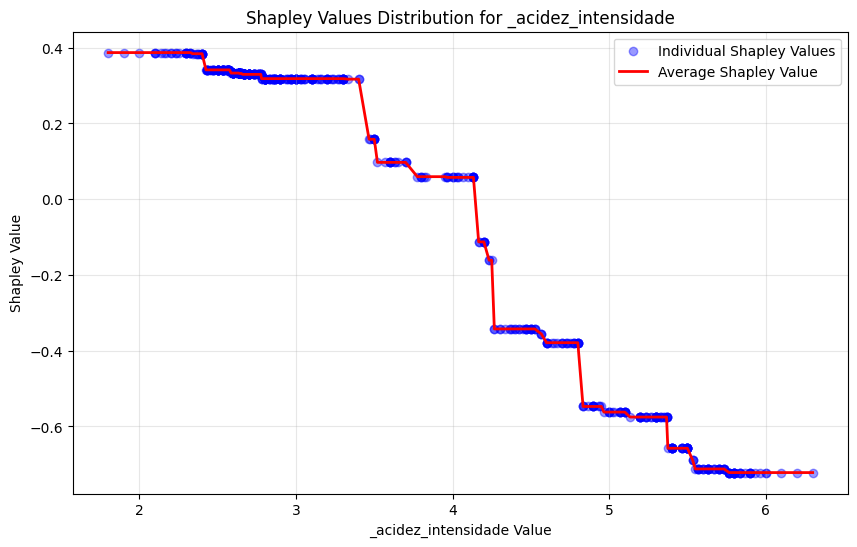

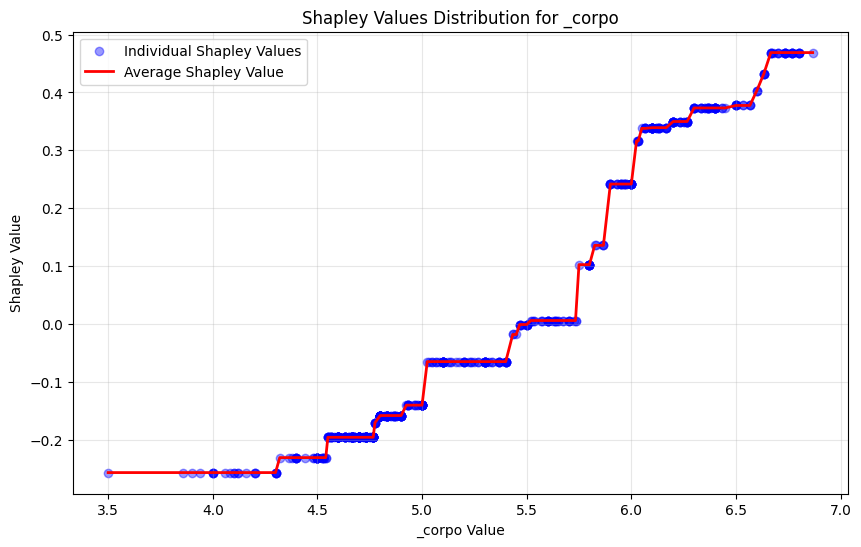

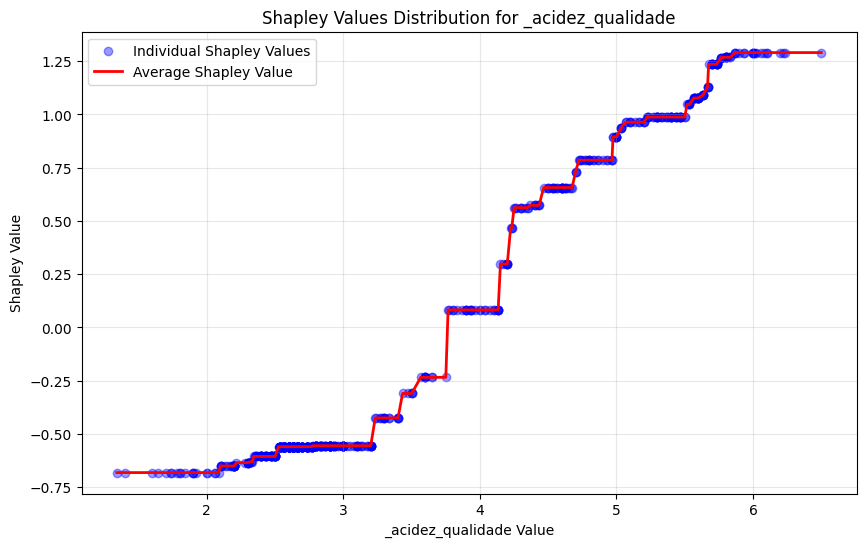

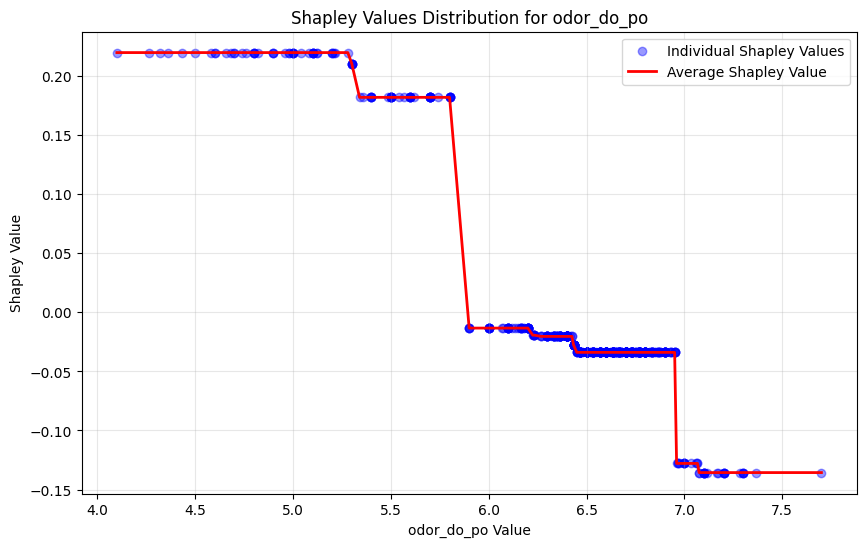

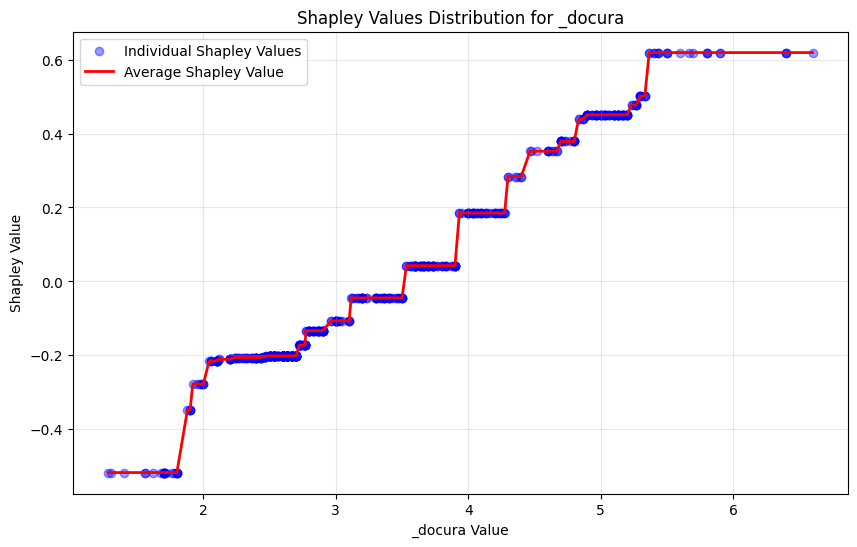

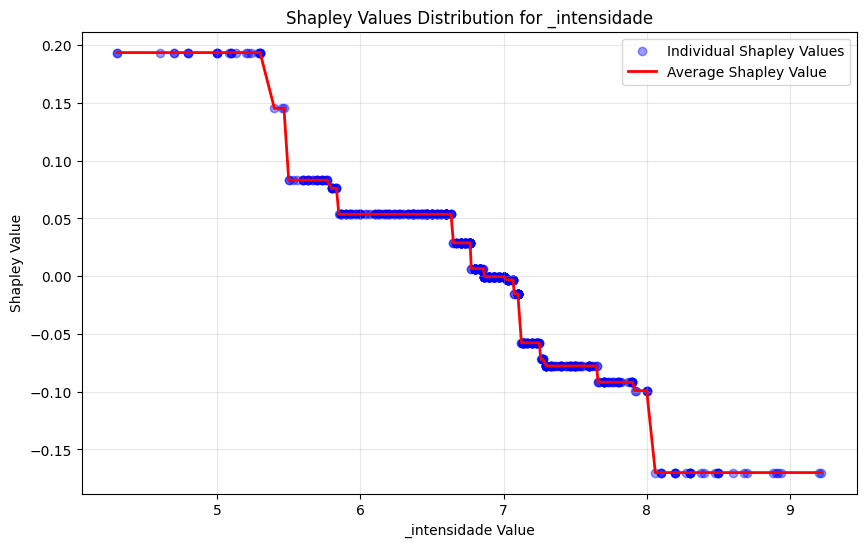

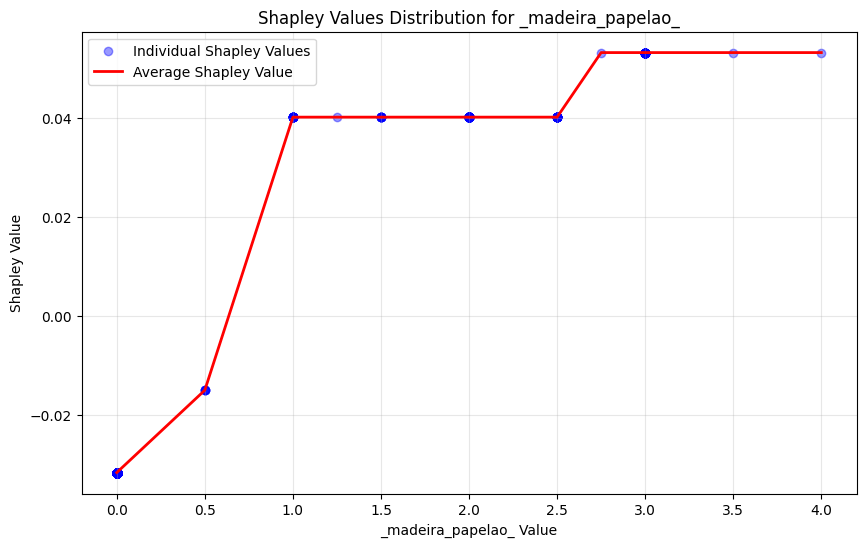

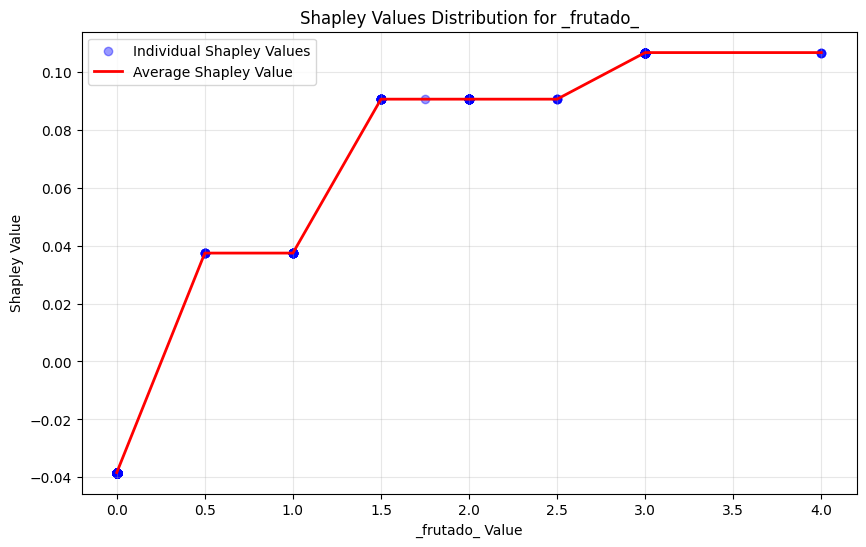

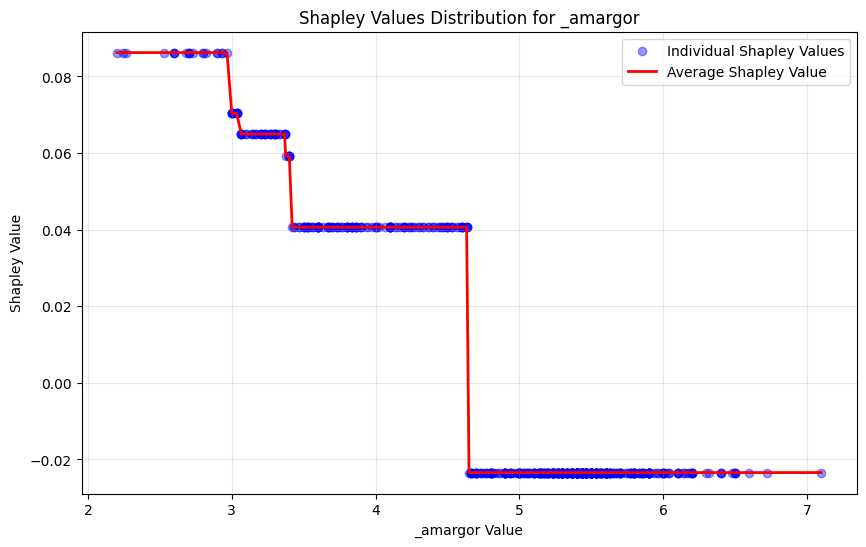

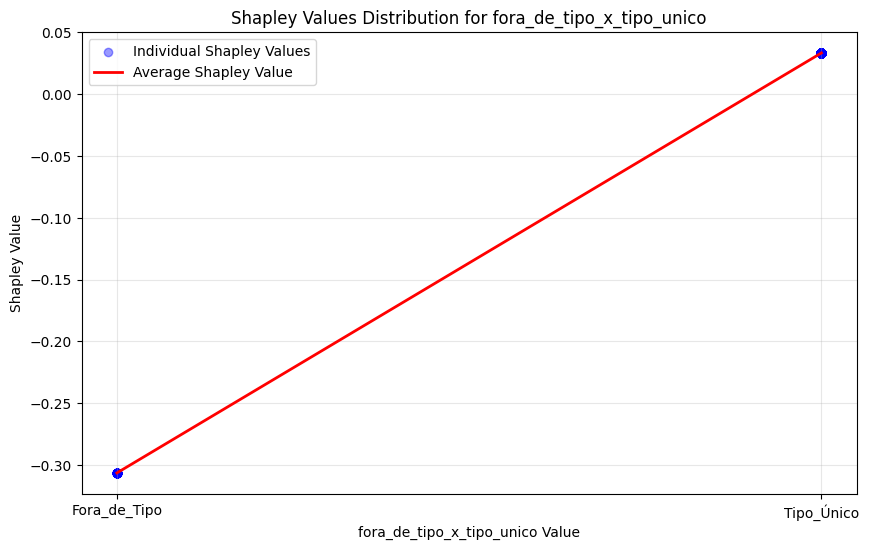

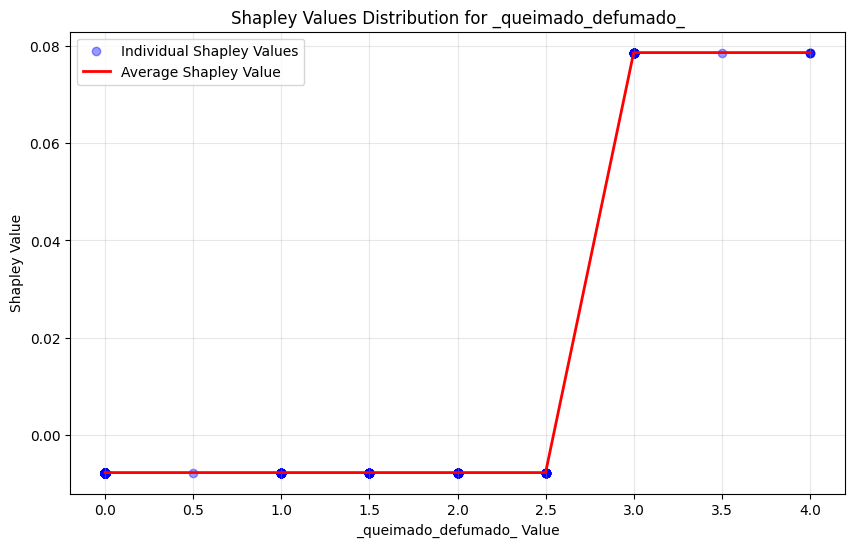

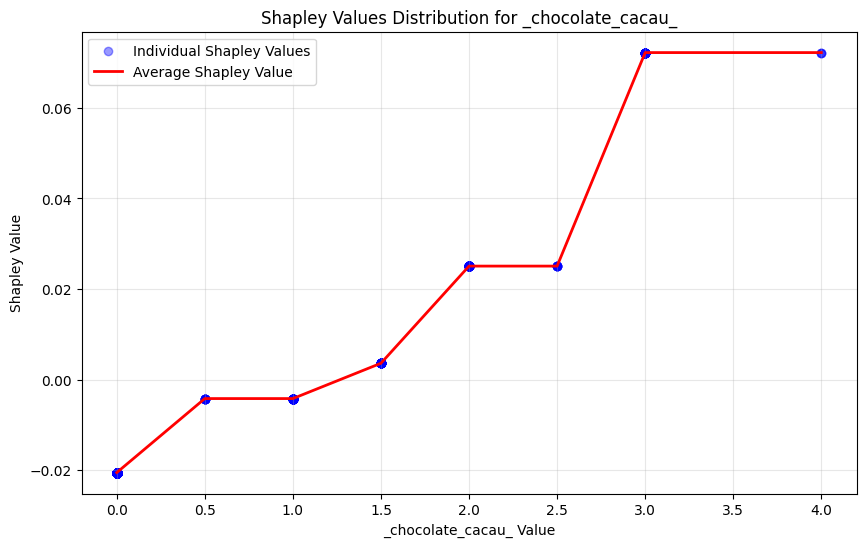

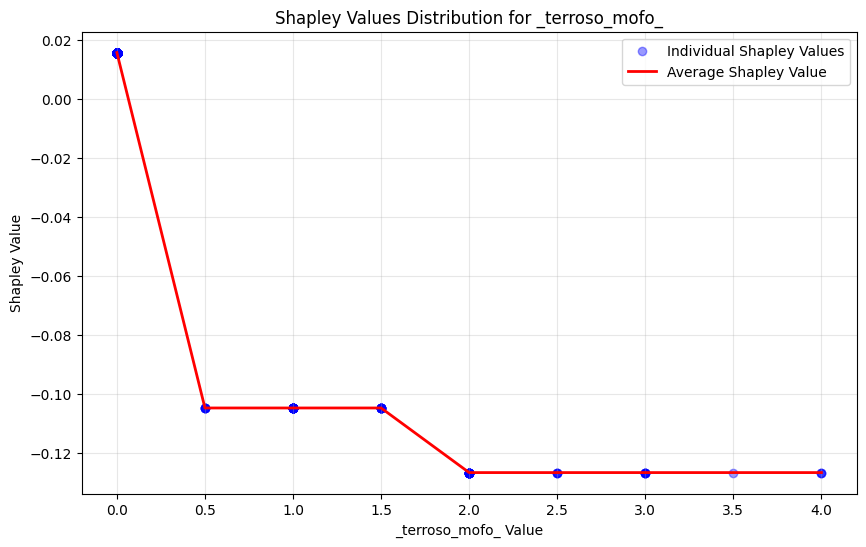

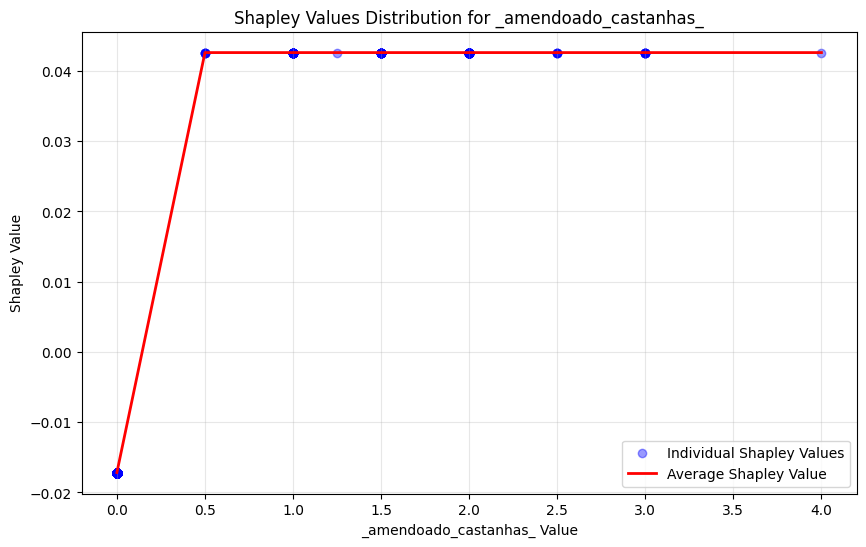

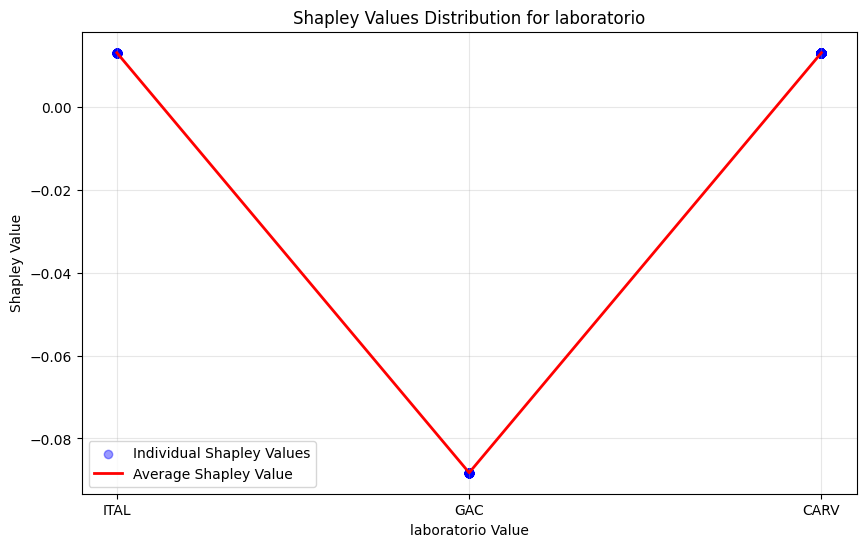

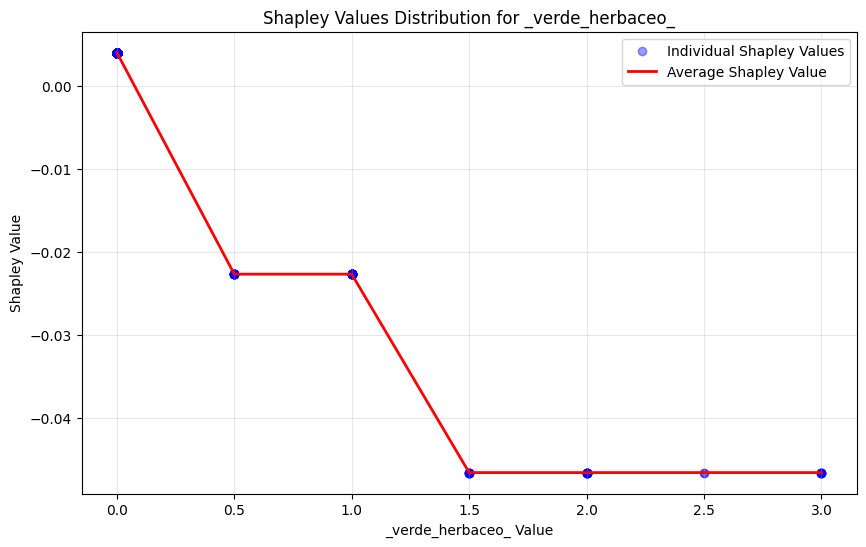

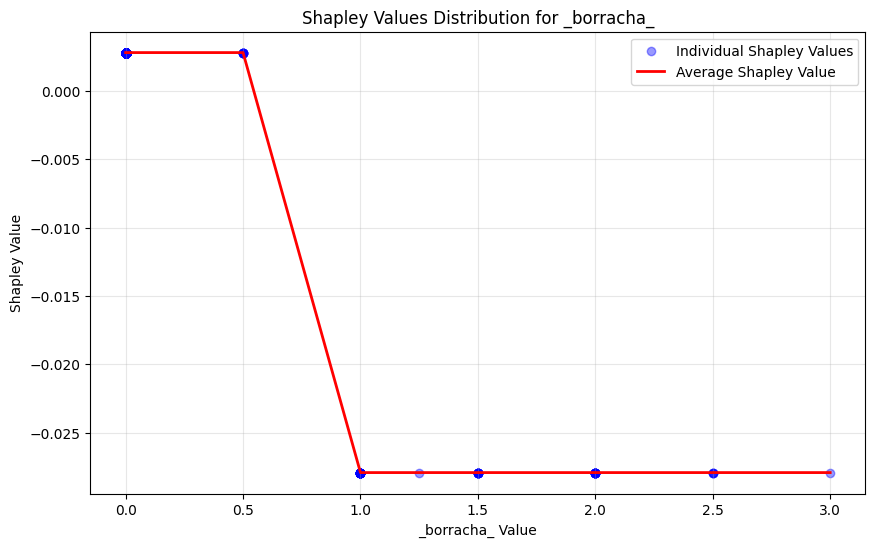

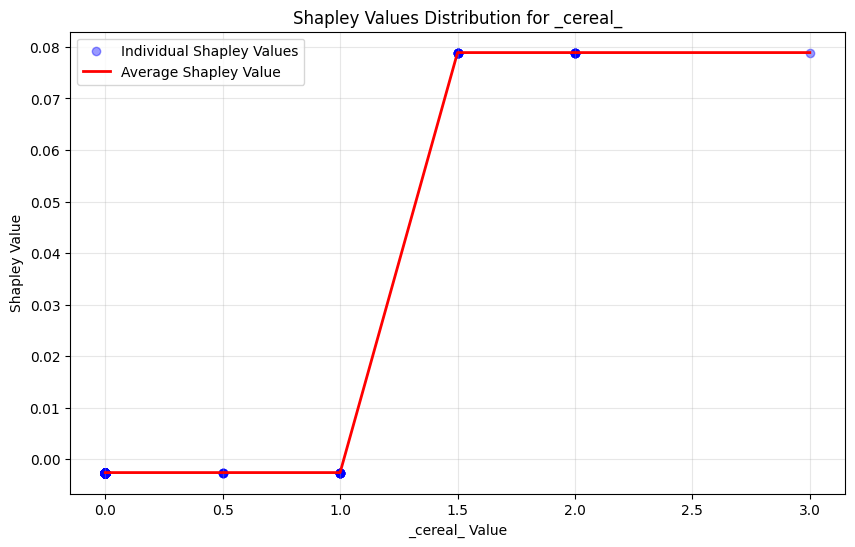

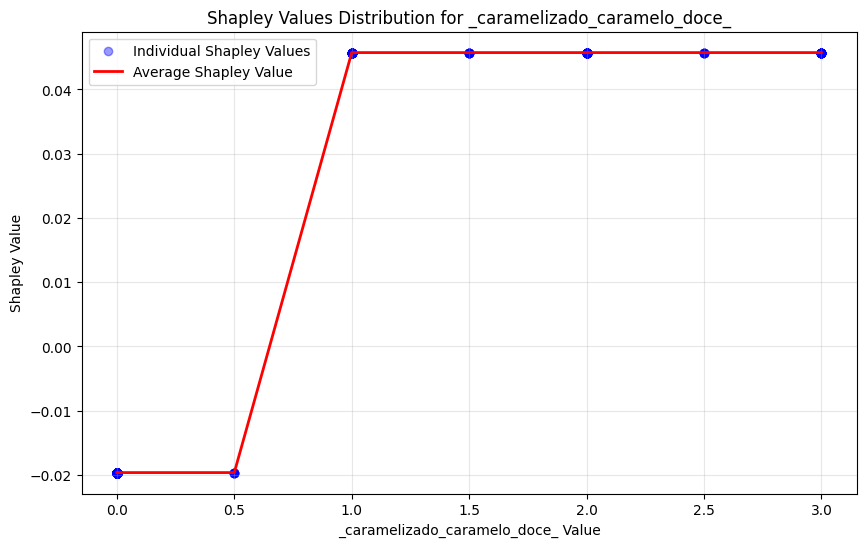

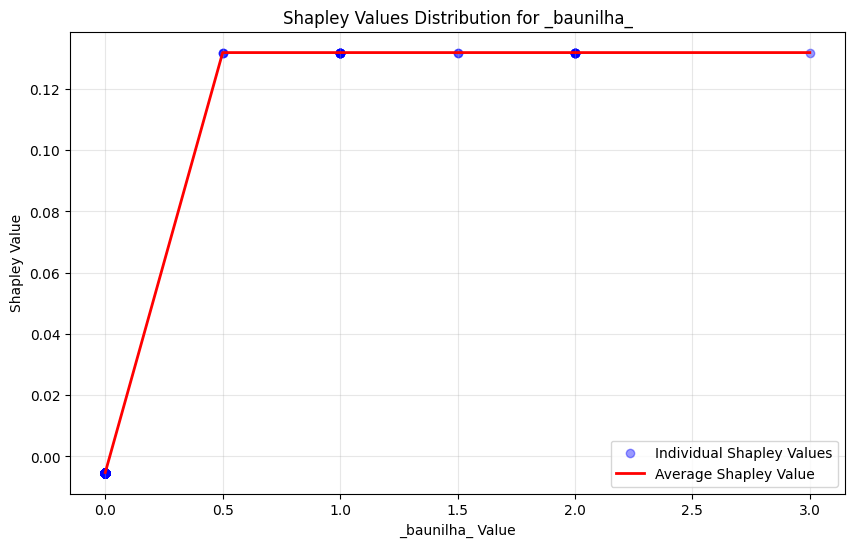

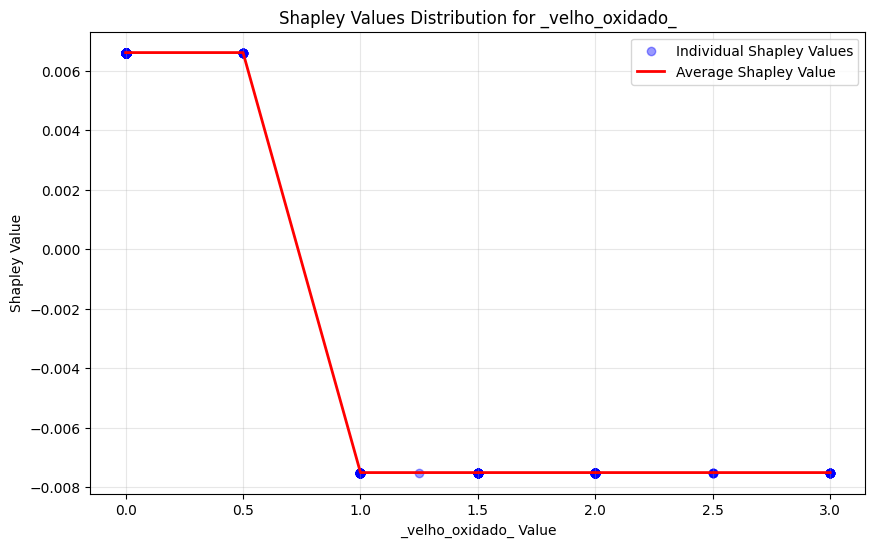

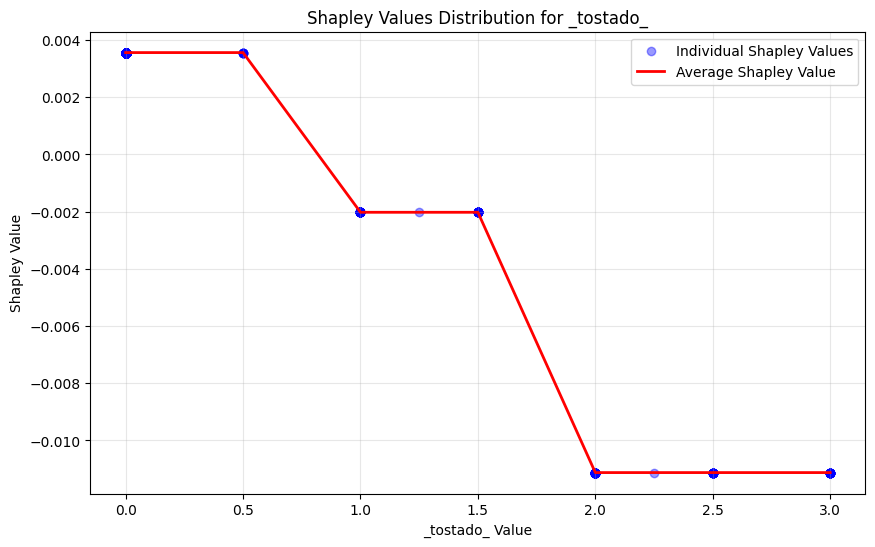

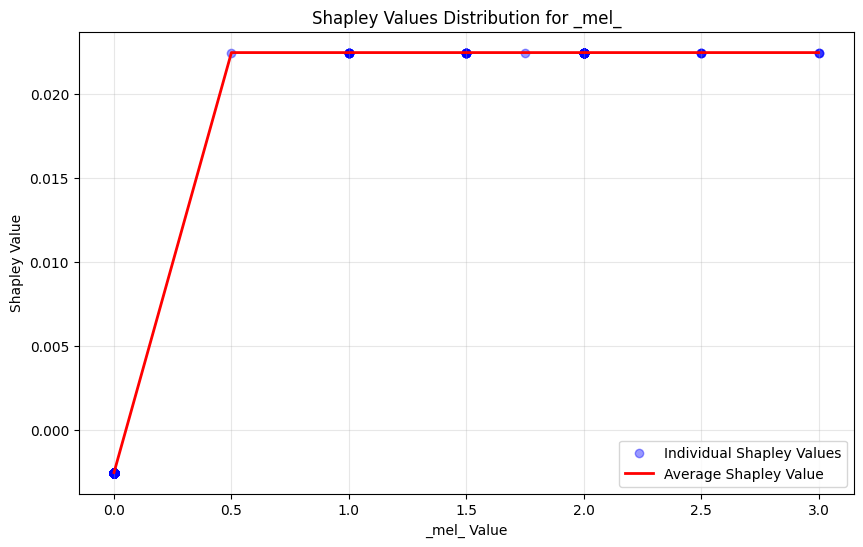

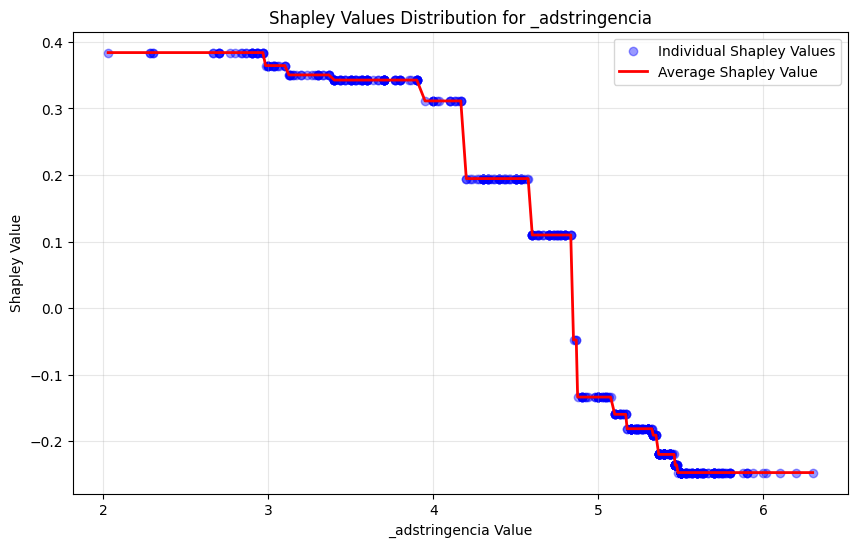

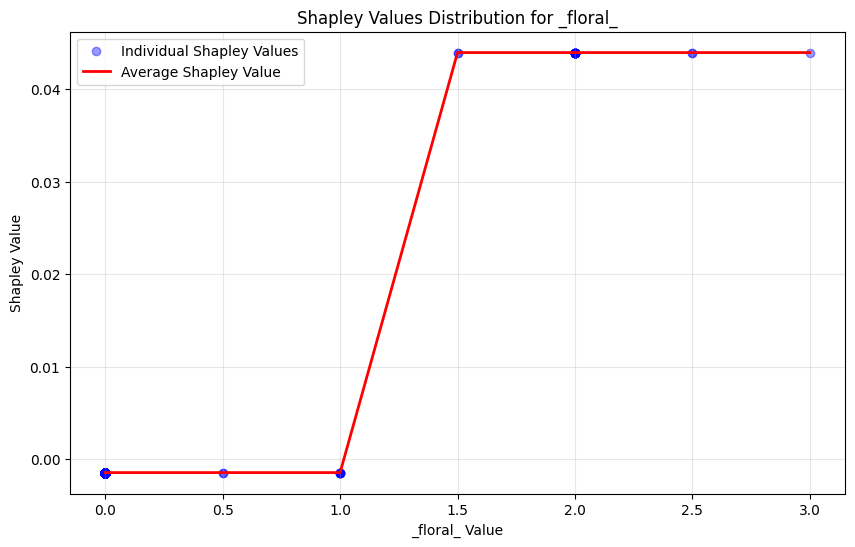

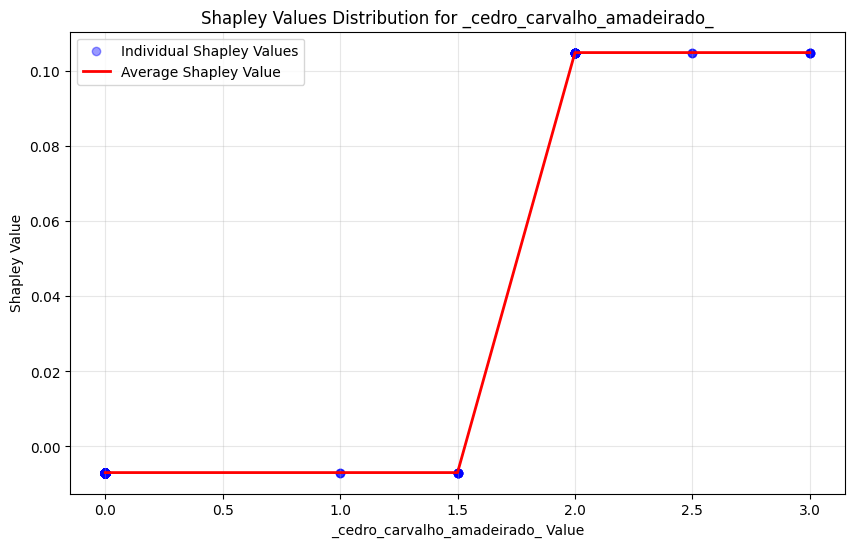

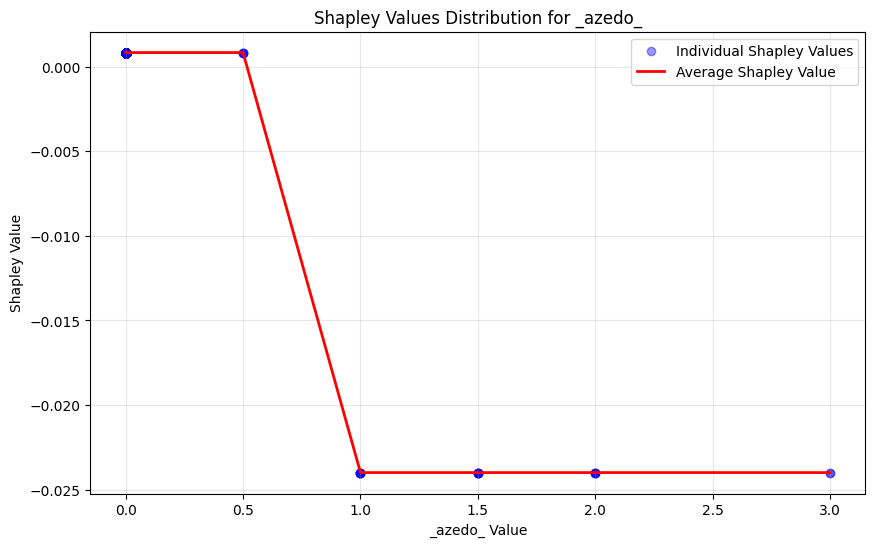

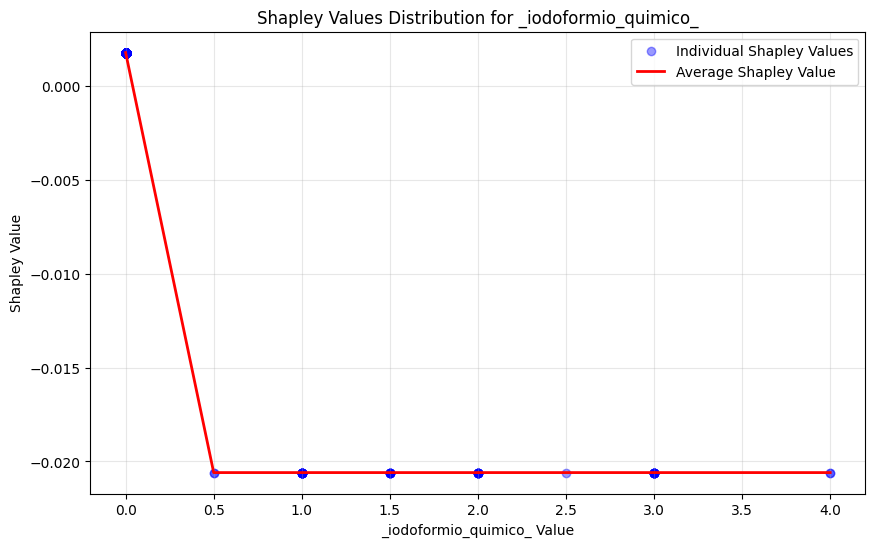

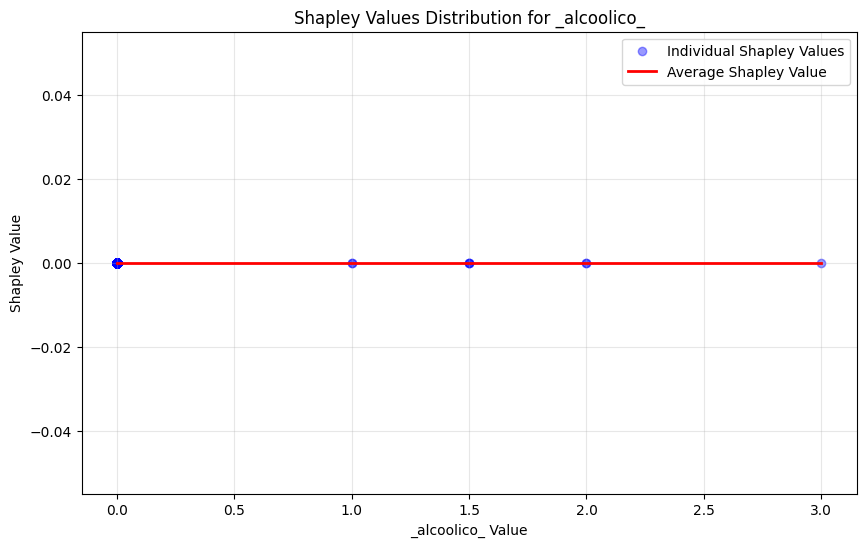

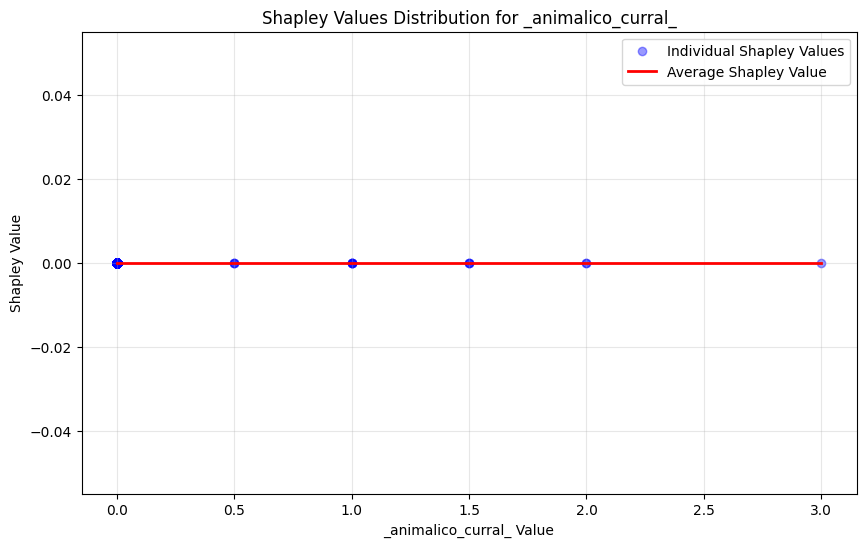

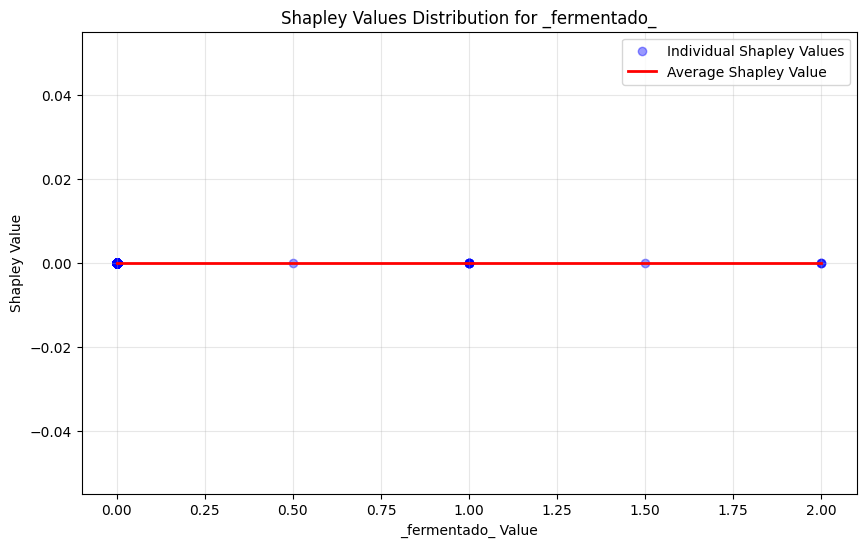

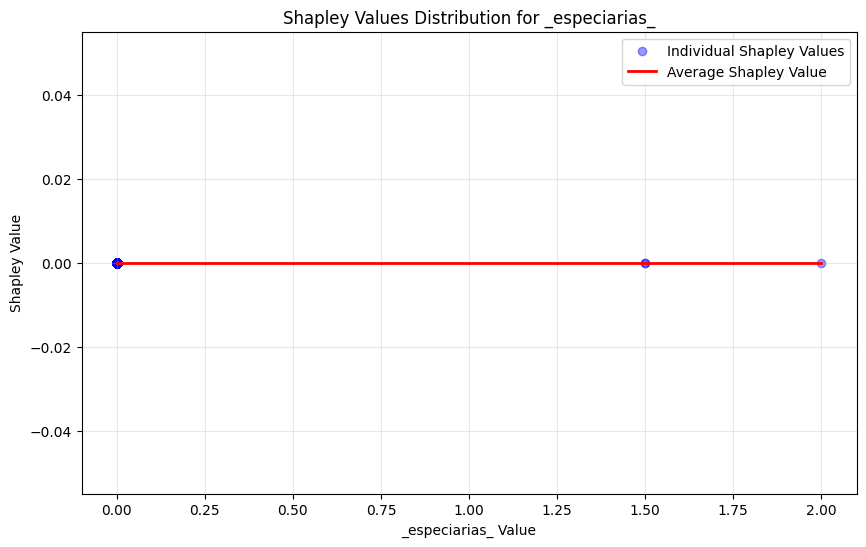

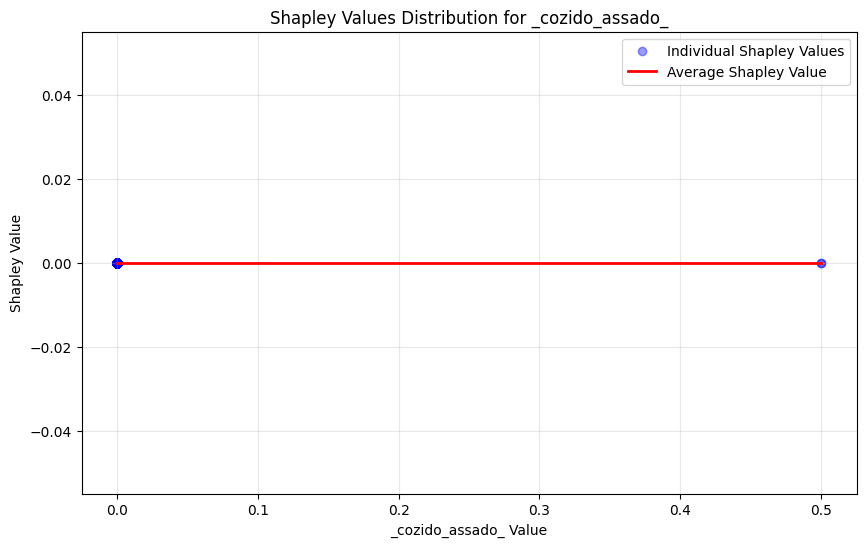

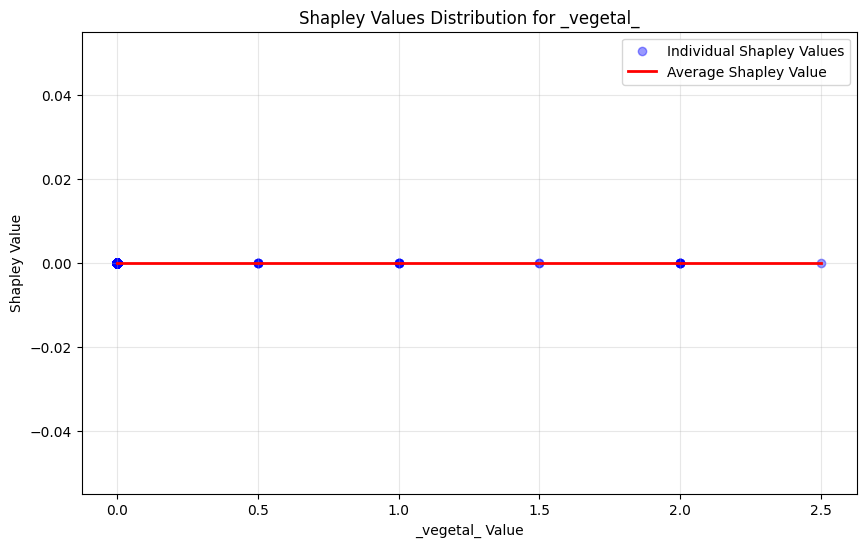

In [117]:
from func import plot_shapley_values

for name in main_imp.index.values:
    plot_shapley_values(shap_df,trn_data ,name)


# <a id='toc7_'></a>[Interaction analysis](#toc0_)

In [118]:
est_data = trn_data.copy()
for cat_var in categorical_features:
    est_data[cat_var] = est_data[cat_var].cat.codes


In [119]:
from shap.utils import approximate_interactions
import shap

exp = TreeExplainer(int_mdl)
shap_interaction_values = exp.shap_interaction_values(est_data)
shap_vals = exp.shap_values(trn_data)


shap_df = pd.DataFrame(shap_vals, columns=trn_data.columns)
int_order = {}

for col in trn_data.columns:
   int_order[col] = approximate_interactions(index=col, shap_values=shap_vals, X=trn_data, feature_names=trn_data.columns)



## <a id='toc7_1_'></a>[Main interactions](#toc0_)

In [120]:
tbl = dict()
for col in int_imp.index.values:

    int_vars = [trn_data.columns[int_order[col][i]] for i in range(3)]
    tbl[col]=int_vars

tbl = pd.DataFrame(tbl).transpose()
tbl.index.name = "Feature"
tbl.columns = ["Top 1 interaction", "Top 2 interaction", "Top 3 interaction"]
tbl

Top 1 interaction  \
Feature                                               
odor_do_po                      _queimado_defumado_   
_intensidade                      _acidez_qualidade   
_amargor                          _chocolate_cacau_   
_chocolate_cacau_                         _tostado_   
_corpo                                  laboratorio   
_velho_oxidado_                          odor_do_po   
_acidez_intensidade               _acidez_qualidade   
_queimado_defumado_                  _adstringencia   
_adstringencia                         _intensidade   
_docura                                   _tostado_   
_acidez_qualidade                        odor_do_po   
_madeira_papelao_                        odor_do_po   
_tostado_                         _chocolate_cacau_   
fora_de_tipo_x_tipo_unico            _terroso_mofo_   
laboratorio                          _terroso_mofo_   
_caramelizado_caramelo_doce_                _docura   
_terroso_mofo_                              _docura   
_verde_herbaceo_                         odor_do_po   
_frutado_                                   _docura   
_iodoformio_quimico_              _acidez_qualidade   
_borracha_                        _madeira_papelao_   
_mel_                         _amendoado_castanhas_   
_amendoado_castanhas_           _acidez_intensidade   
_cedro_carvalho_amadeirado_       _chocolate_cacau_   
_cereal_                                   _amargor   
_floral_                      _amendoado_castanhas_   
_baunilha_                                   _corpo   
_azedo_                                     _docura   
_alcoolico_                             laboratorio   
_animalico_curral_                      laboratorio   
_fermentado_                            laboratorio   
_especiarias_                           laboratorio   
_cozido_assado_                         laboratorio   
_vegetal_                               laboratorio   

                                      Top 2 interaction    Top 3 interaction  
Feature                                                                       
odor_do_po                               _terroso_mofo_             _cereal_  
_intensidade                             _adstringencia             _amargor  
_amargor                              _acidez_qualidade       _adstringencia  
_chocolate_cacau_                     _madeira_papelao_          laboratorio  
_corpo                                        _tostado_    _madeira_papelao_  
_velho_oxidado_                                  _corpo    _acidez_qualidade  
_acidez_intensidade                             _docura         _intensidade  
_queimado_defumado_                 _acidez_intensidade    _acidez_qualidade  
_adstringencia                              laboratorio             _amargor  
_docura                                      odor_do_po         _intensidade  
_acidez_qualidade                   _acidez_intensidade          laboratorio  
_madeira_papelao_                          _intensidade              _docura  
_tostado_                                        _corpo    _acidez_qualidade  
fora_de_tipo_x_tipo_unico           _queimado_defumado_    _madeira_papelao_  
laboratorio                         _queimado_defumado_         _intensidade  
_caramelizado_caramelo_doce_        _acidez_intensidade    _acidez_qualidade  
_terroso_mofo_                        _acidez_qualidade  _acidez_intensidade  
_verde_herbaceo_                    _queimado_defumado_              _docura  
_frutado_                                  _intensidade    _chocolate_cacau_  
_iodoformio_quimico_                            _docura  _acidez_intensidade  
_borracha_                                       _corpo    _acidez_qualidade  
_mel_                                 _chocolate_cacau_    _acidez_qualidade  
_amendoado_castanhas_                 _acidez_qualidade       _adstringencia  
_cedro_carvalho_amadeirado_             _velho_oxidado_       _adstringencia  

## <a id='toc7_2_'></a>[Interaction plots](#toc0_)

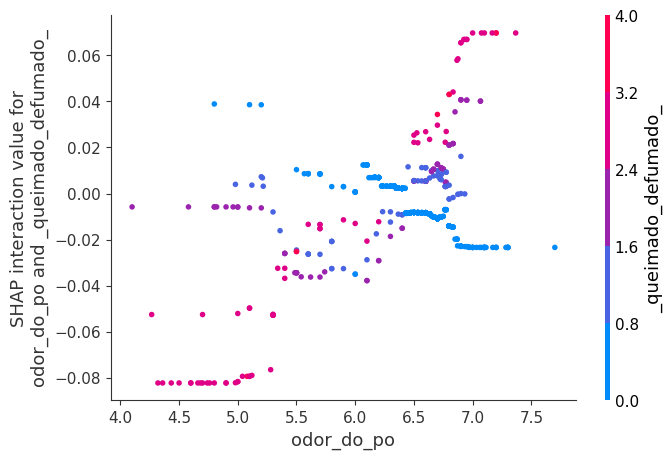

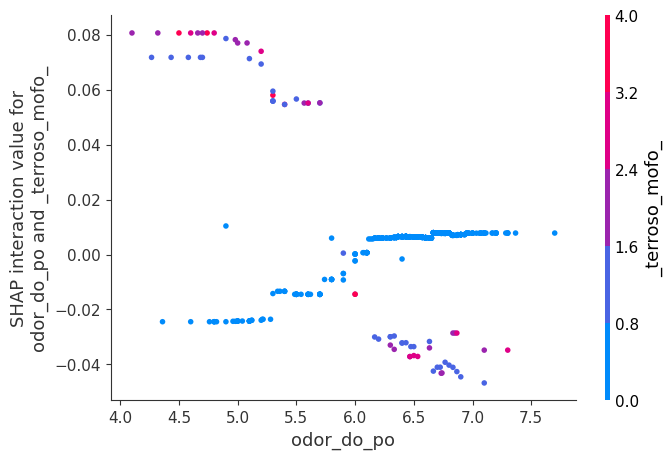

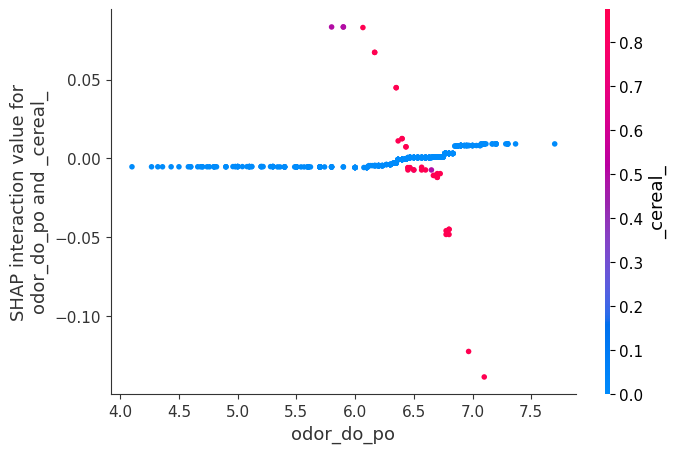

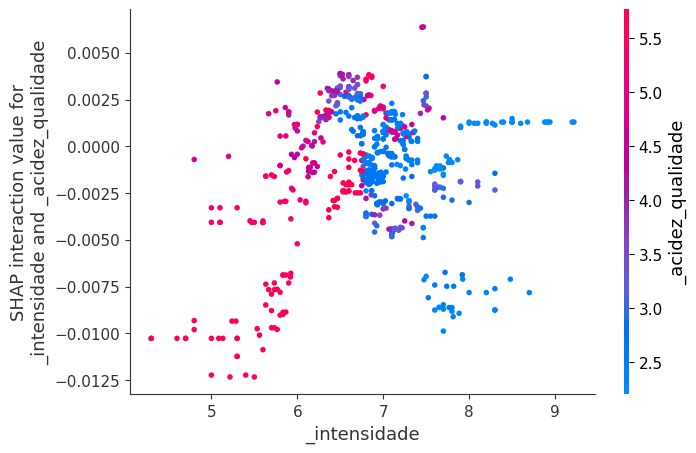

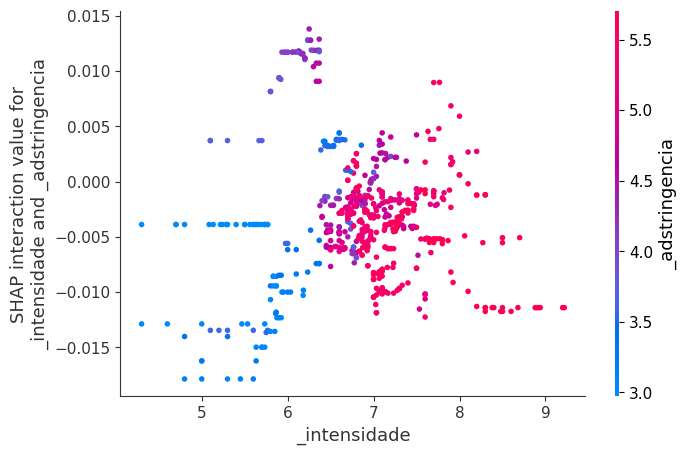

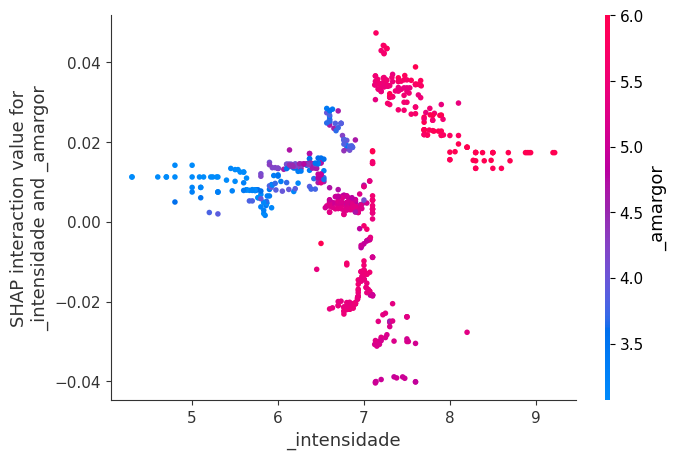

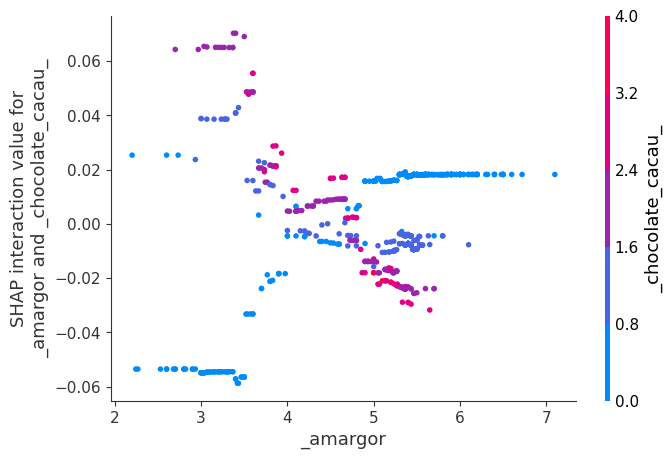

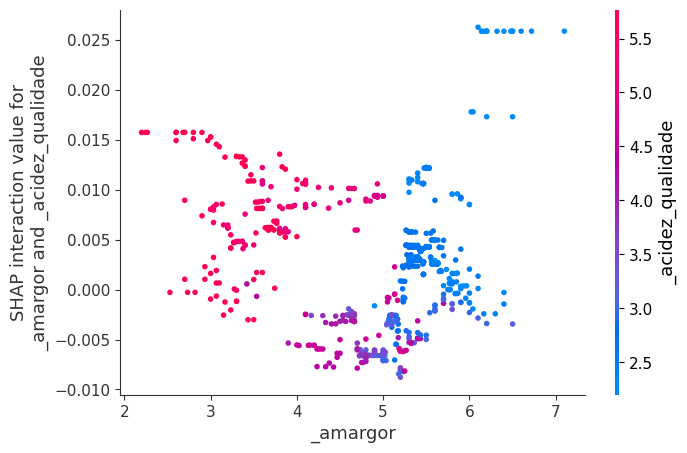

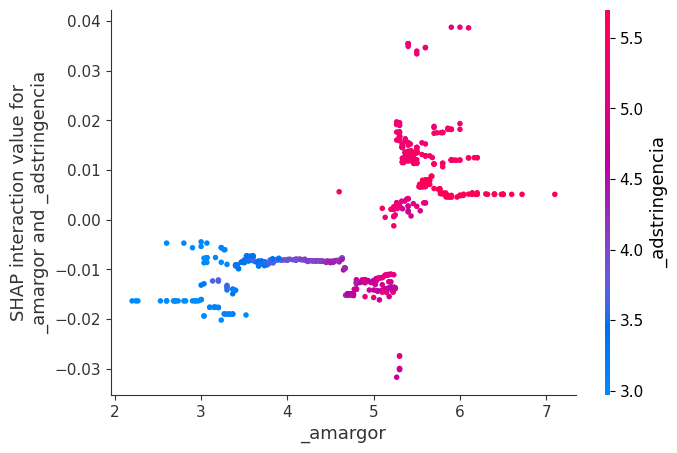

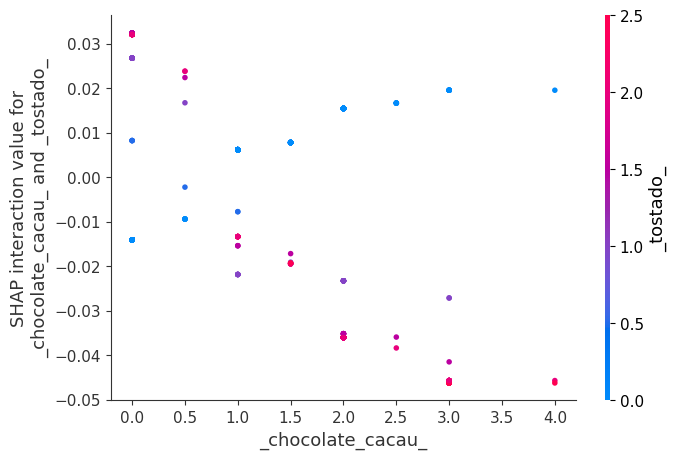

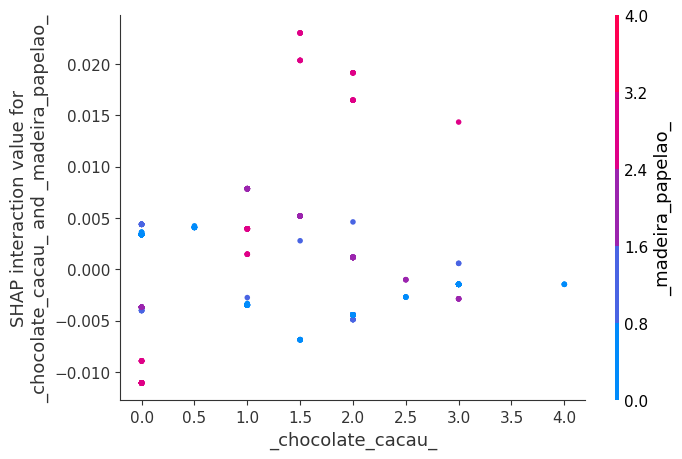

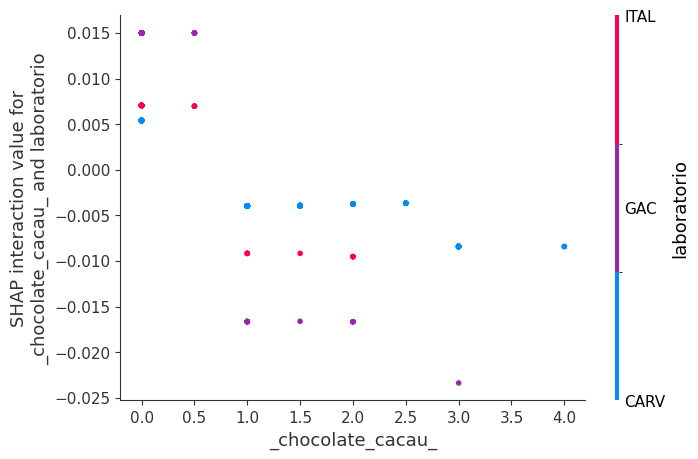

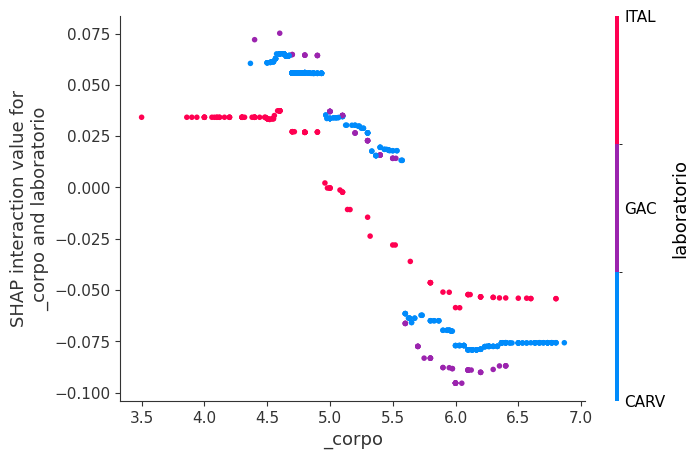

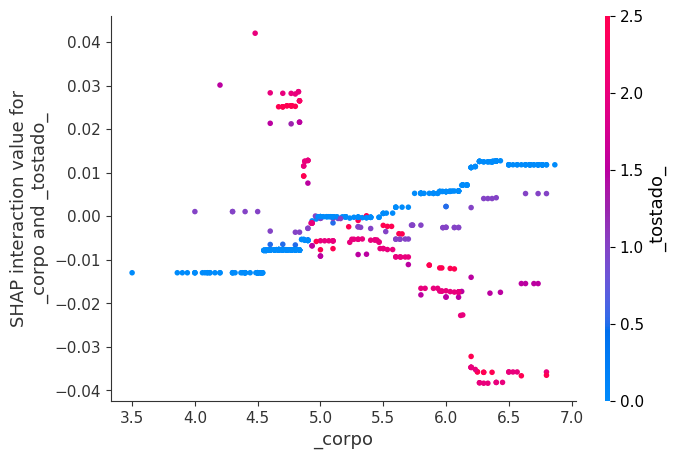

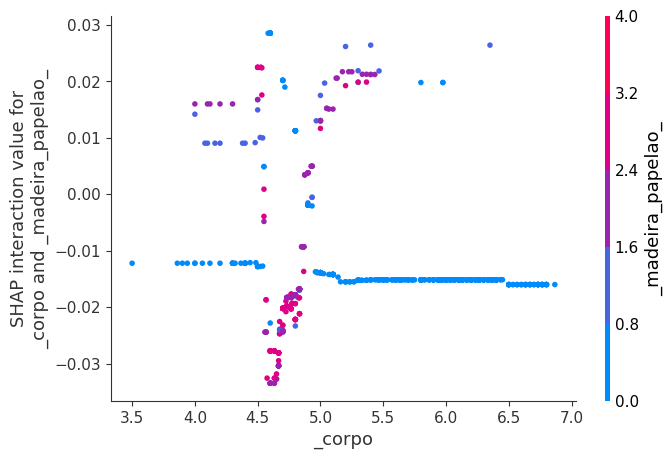

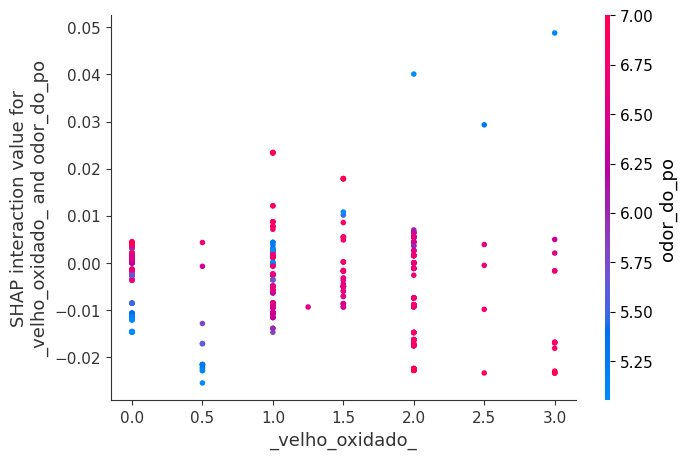

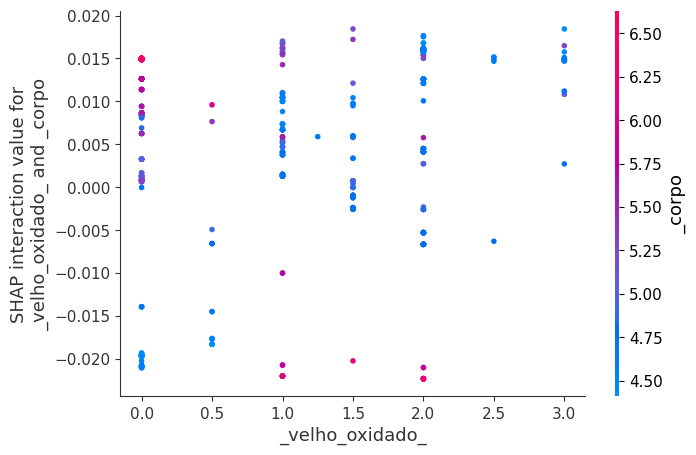

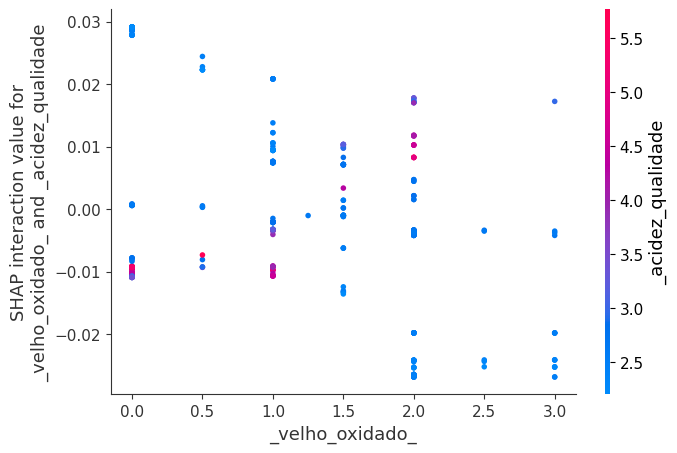

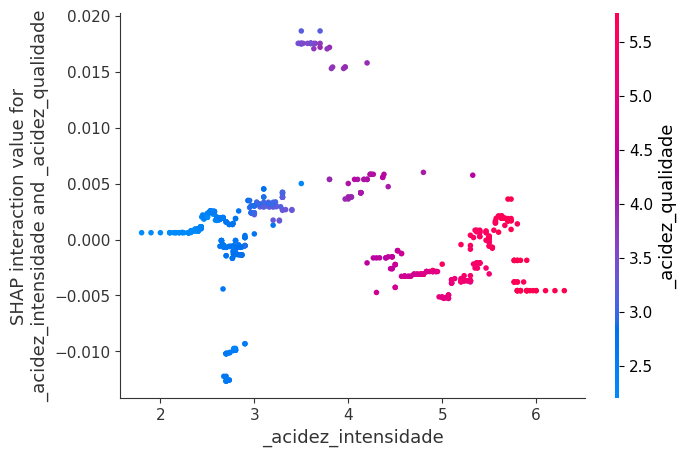

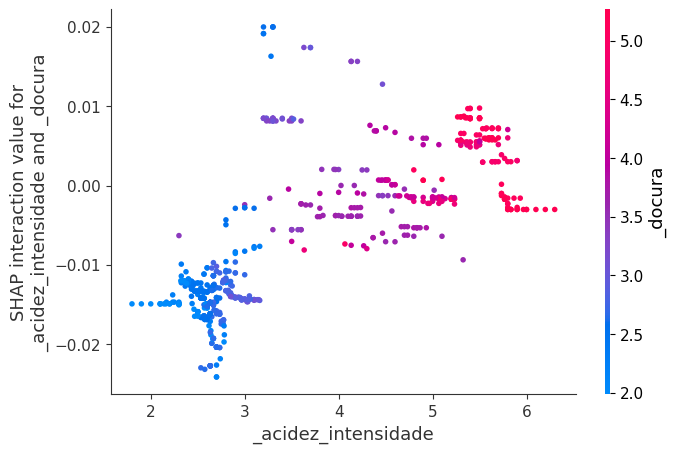

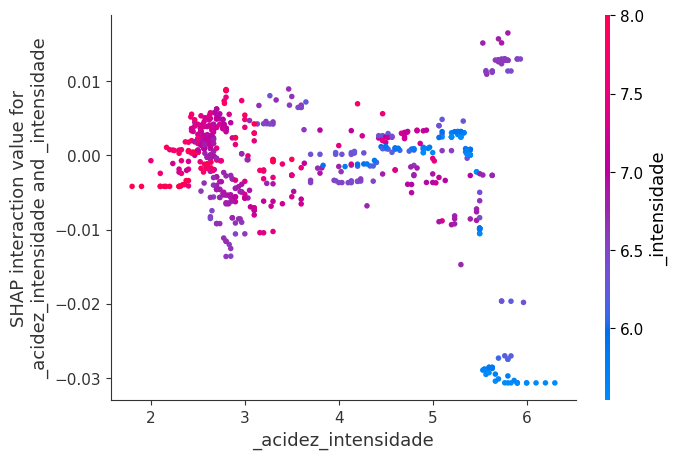

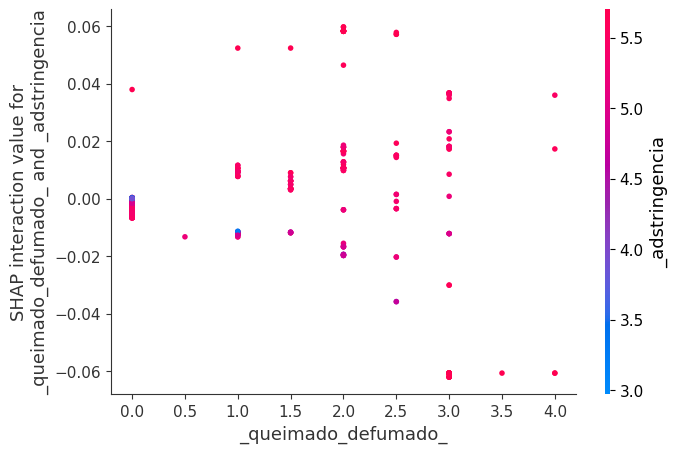

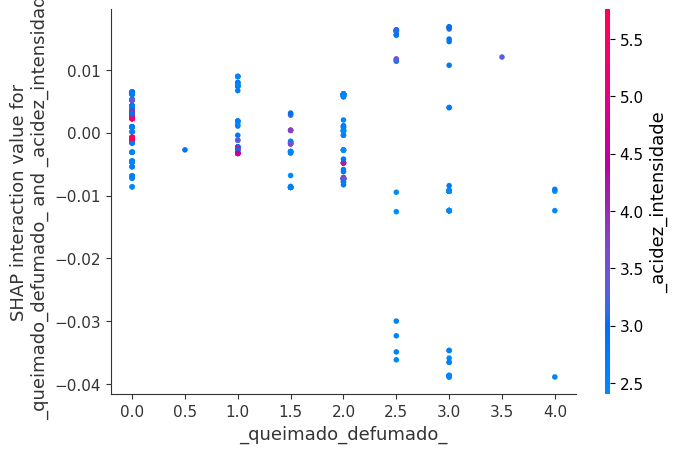

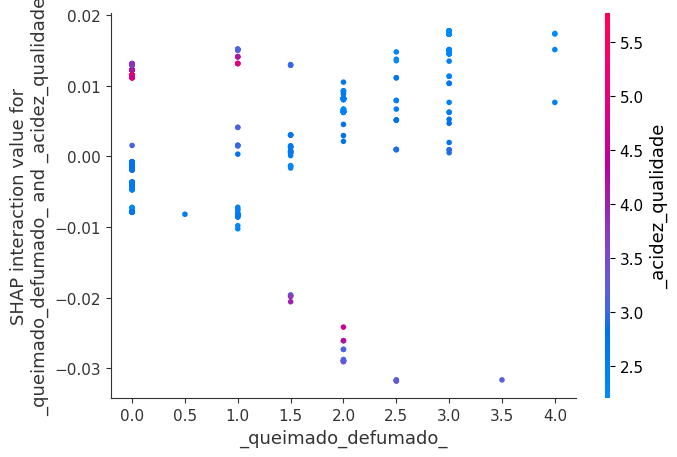

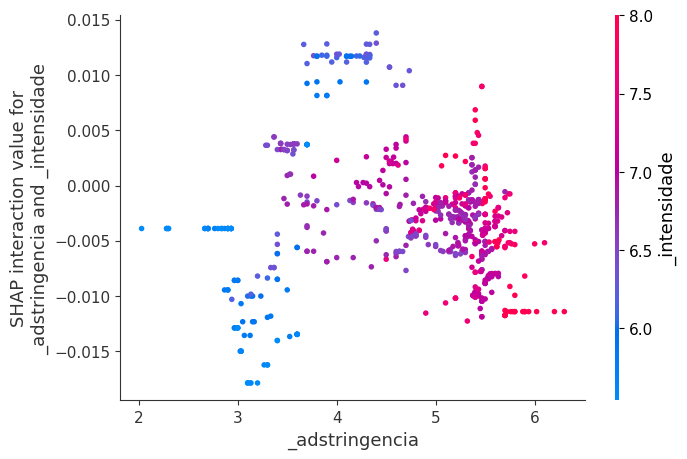

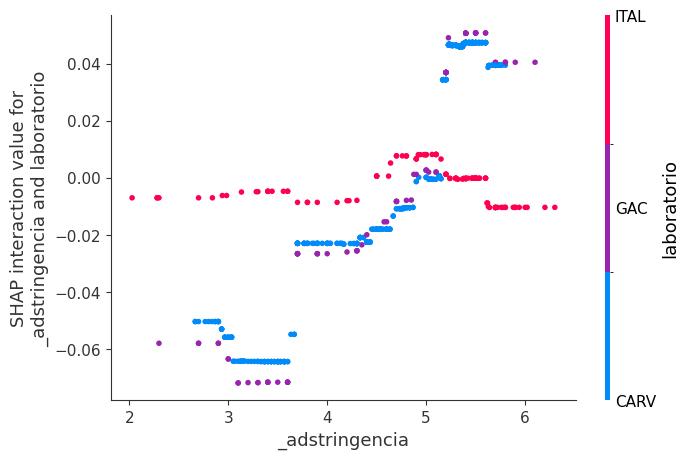

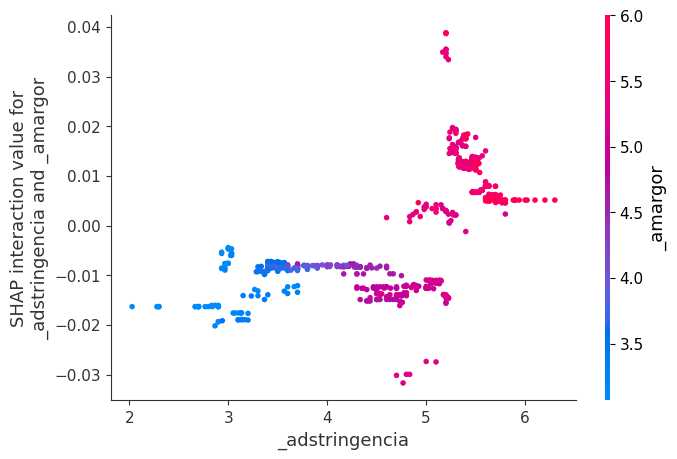

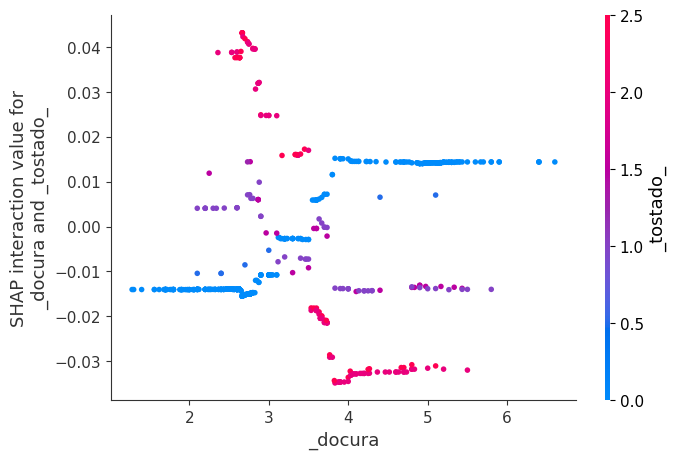

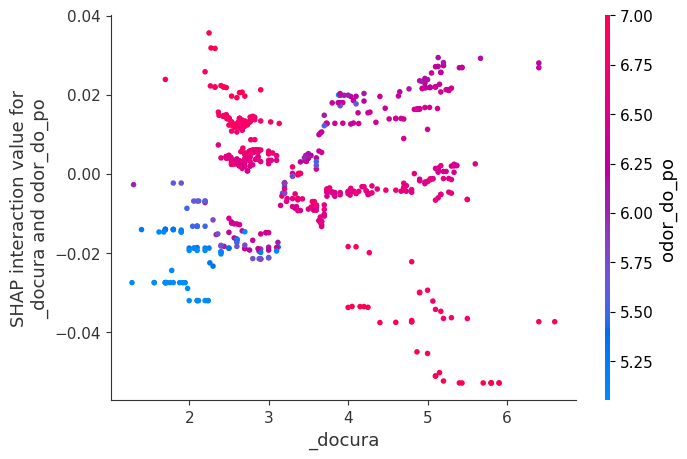

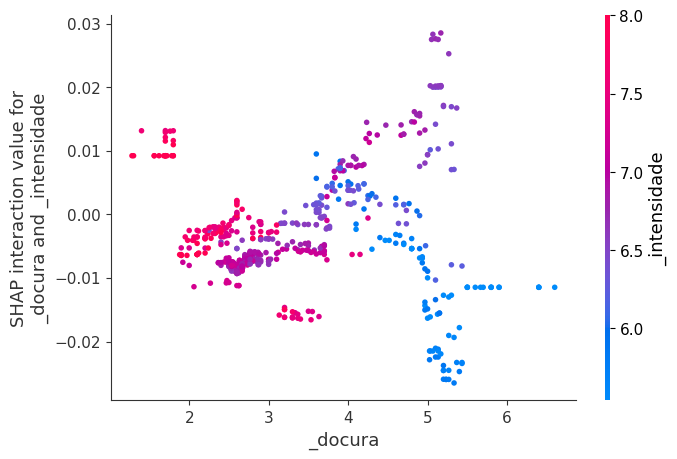

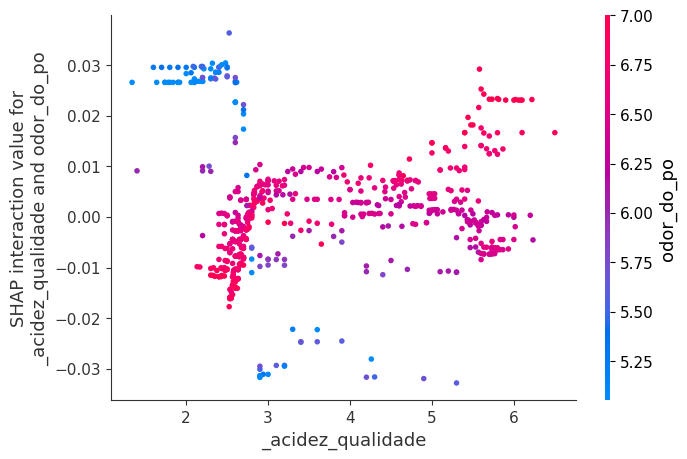

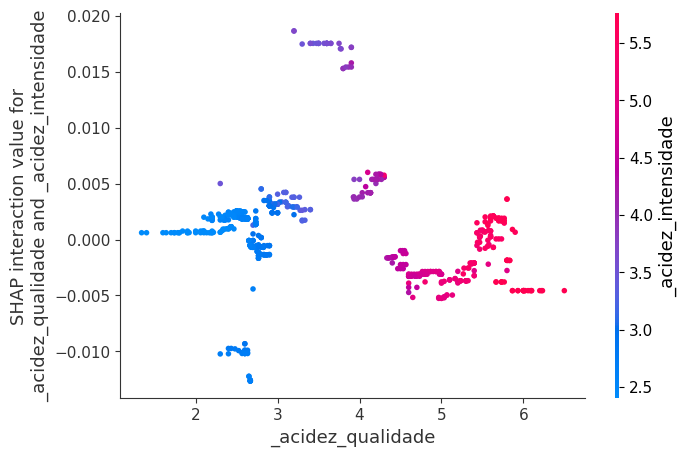

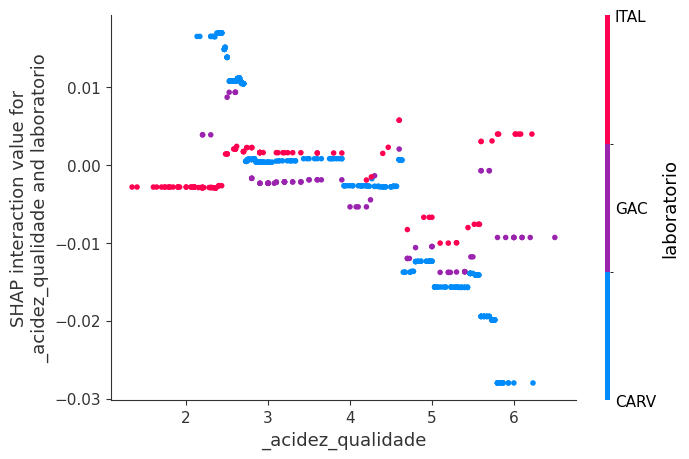

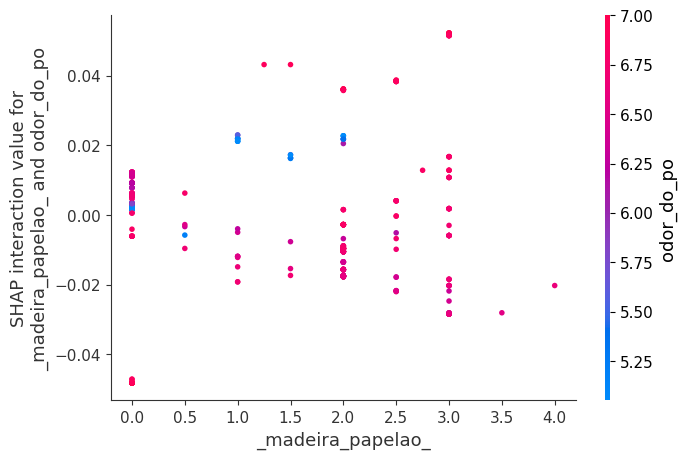

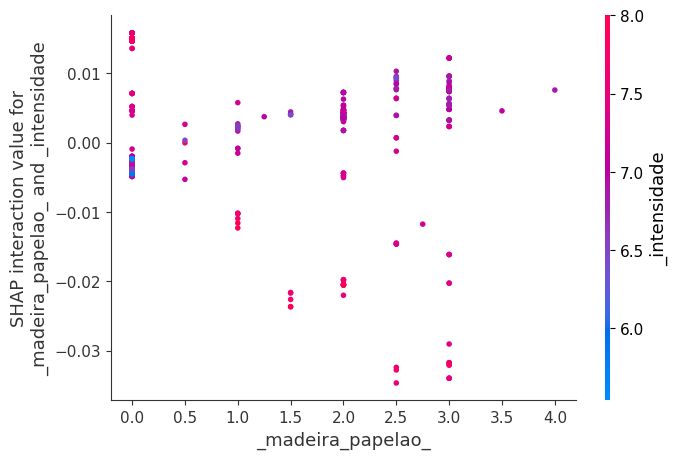

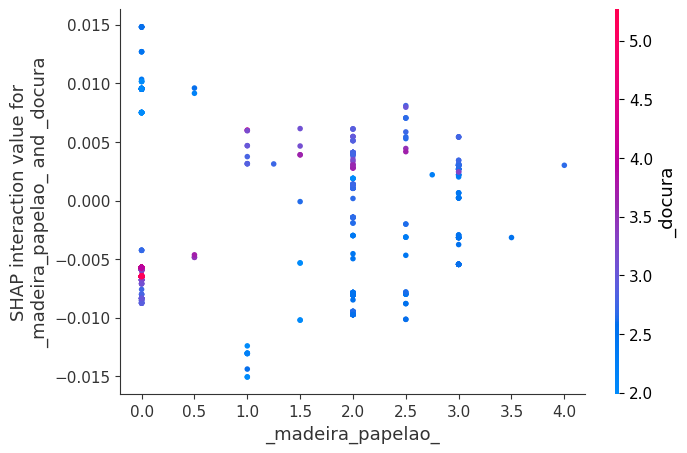

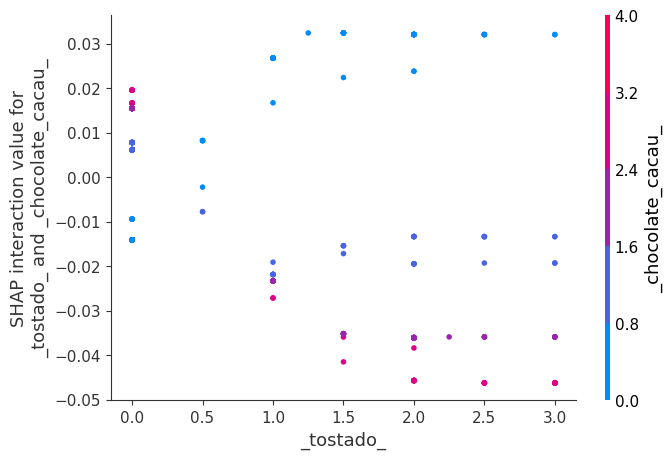

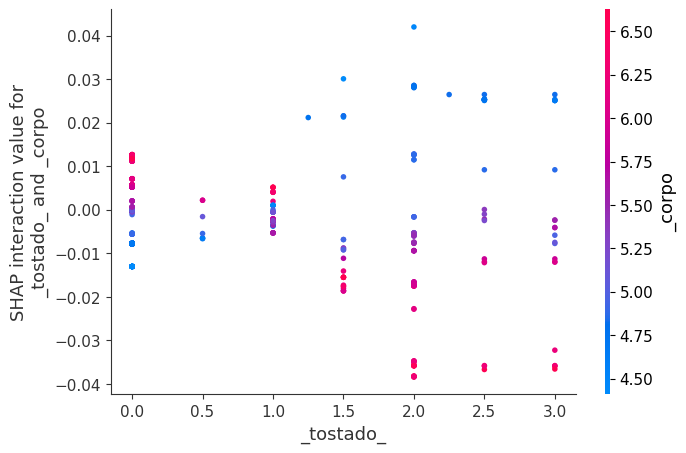

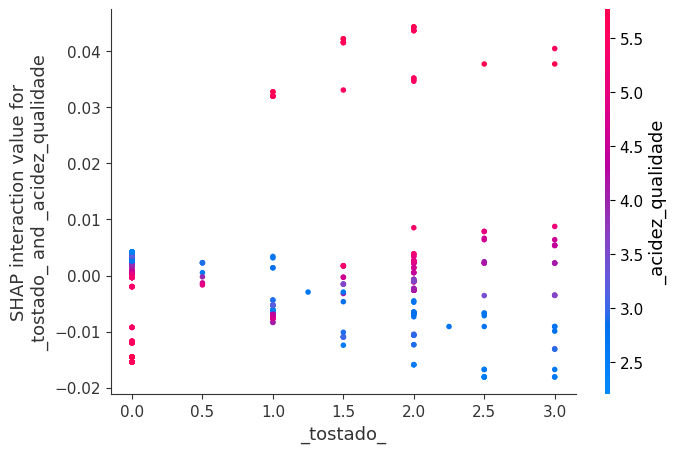

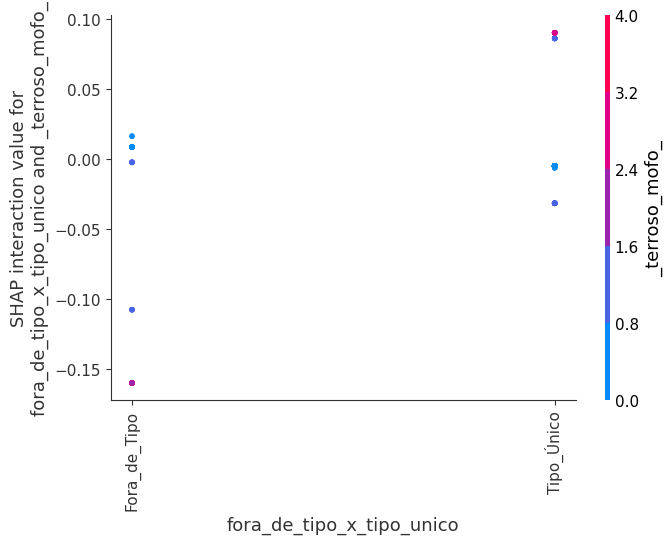

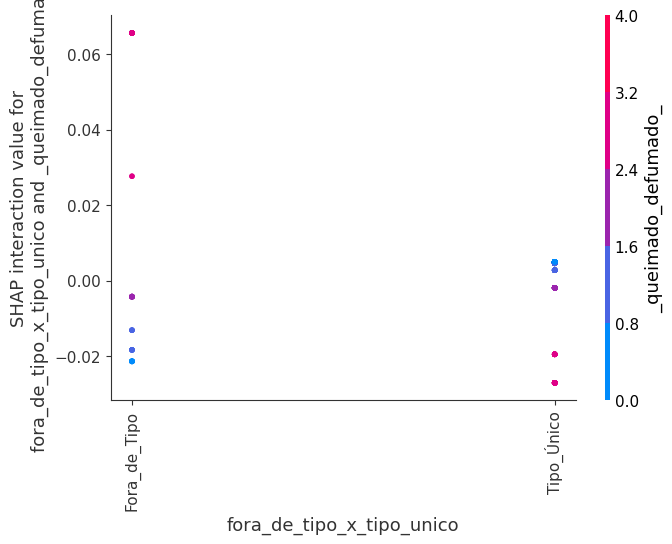

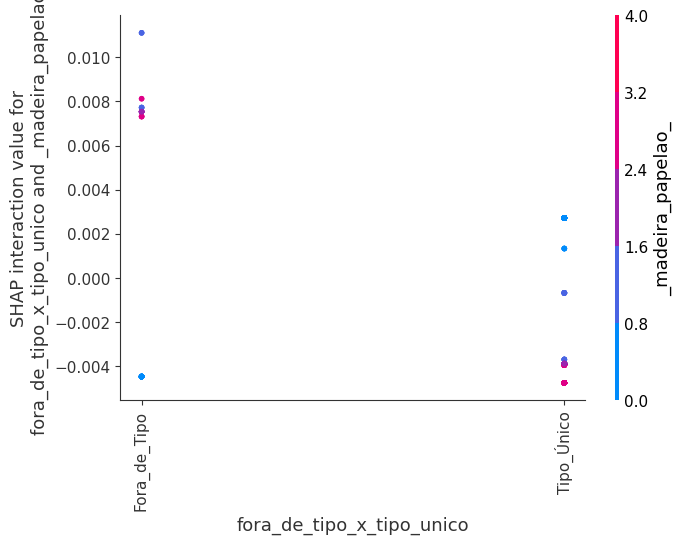

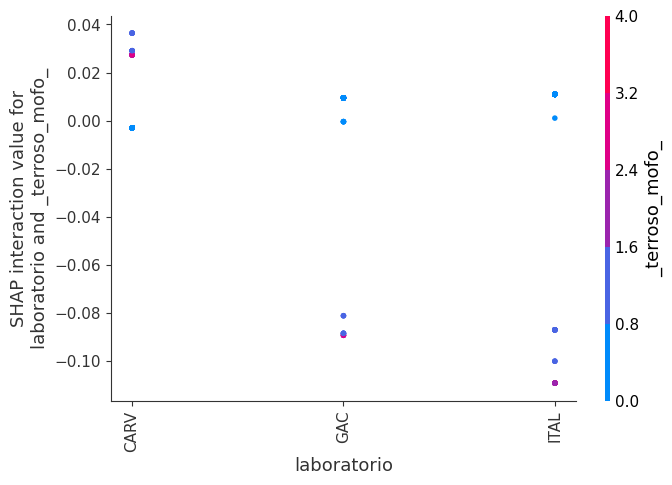

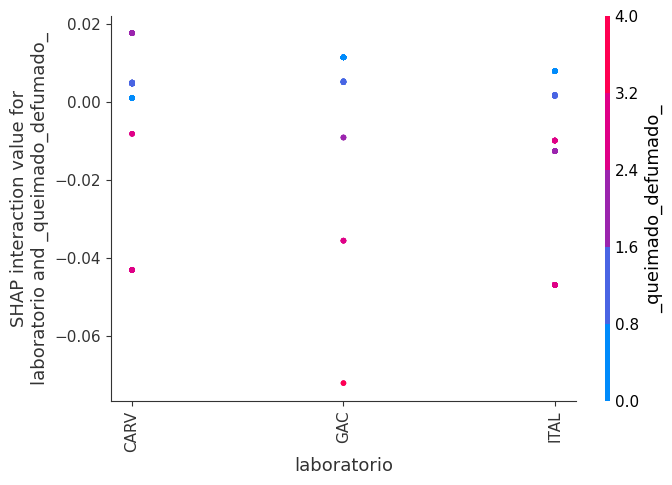

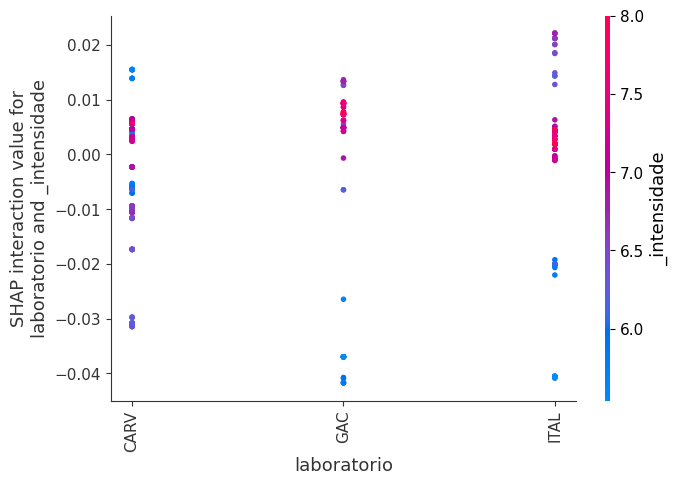

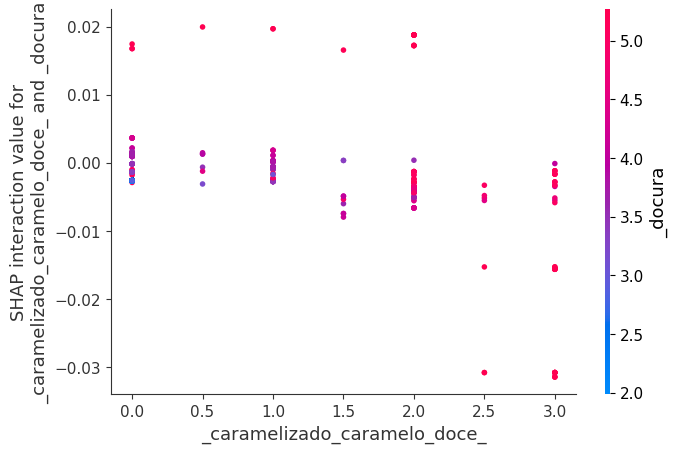

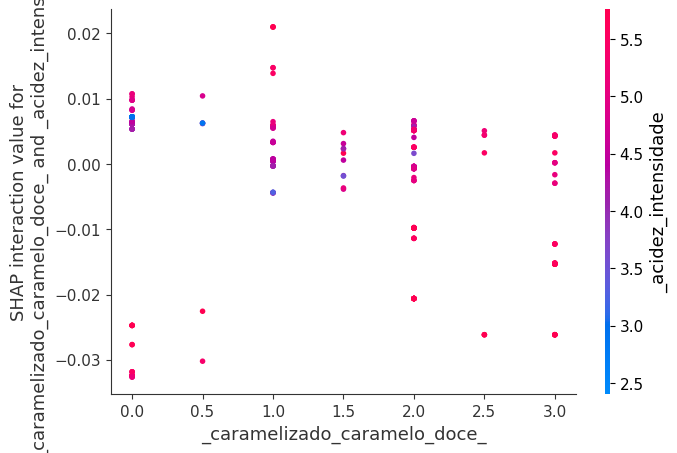

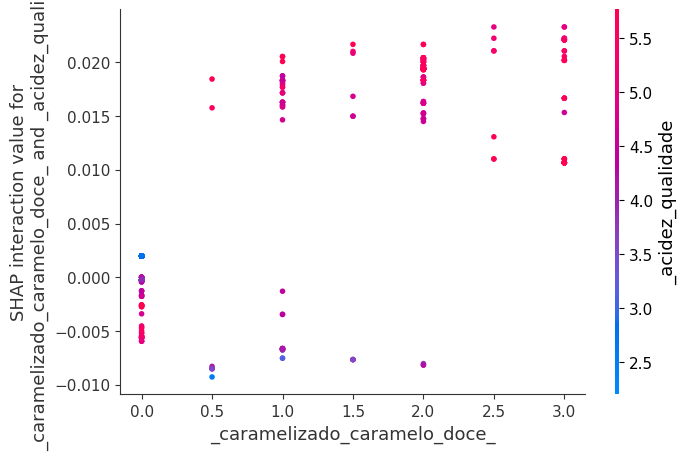

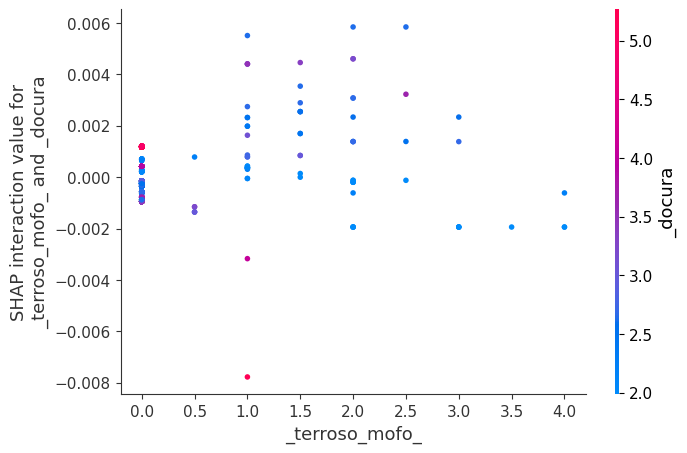

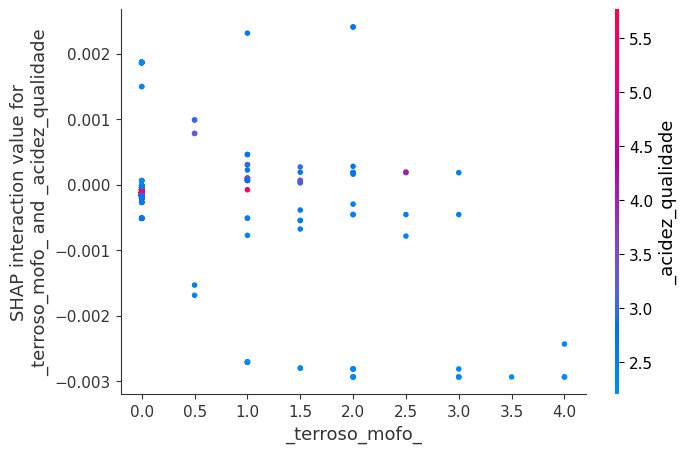

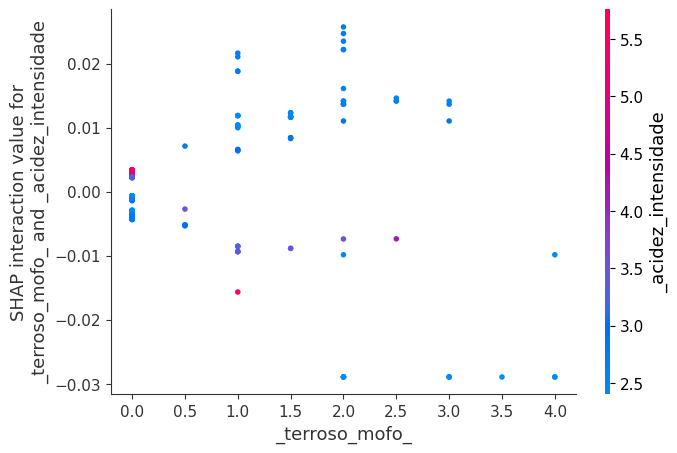

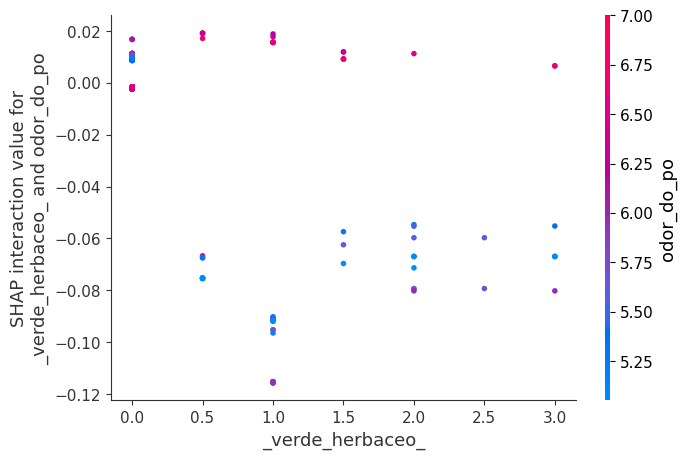

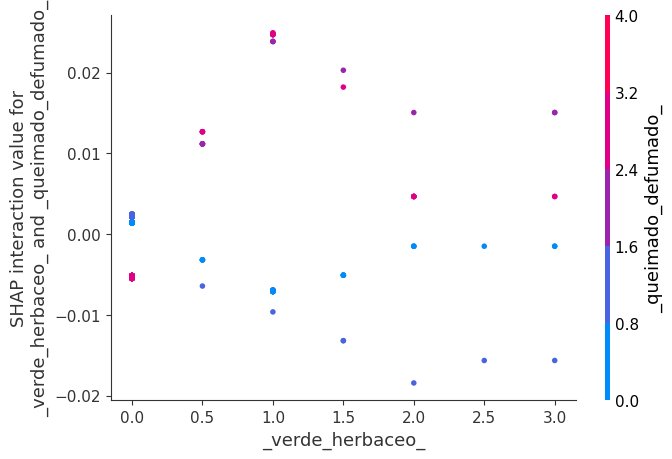

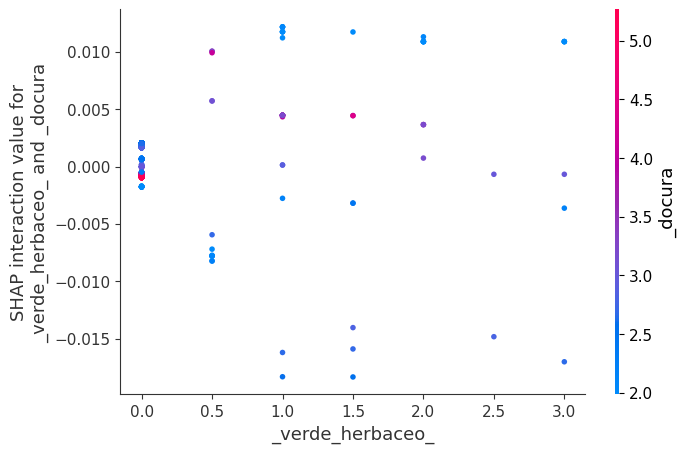

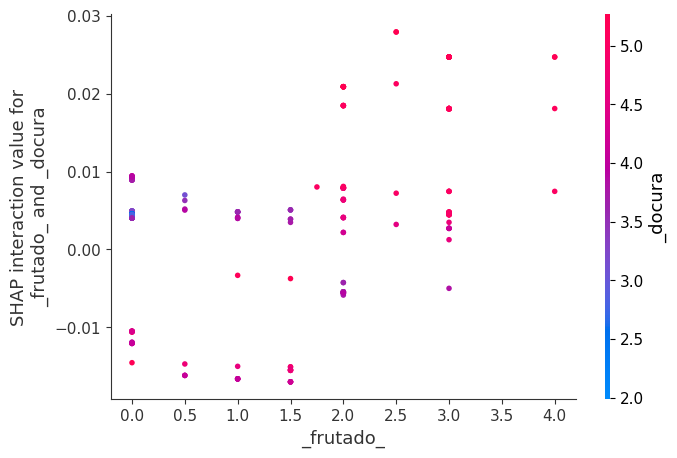

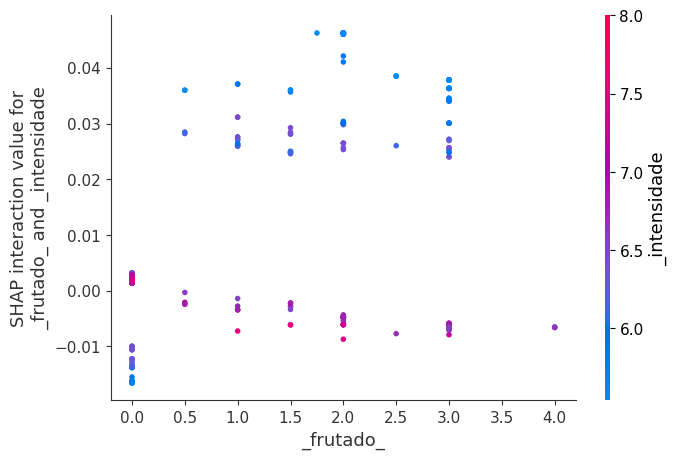

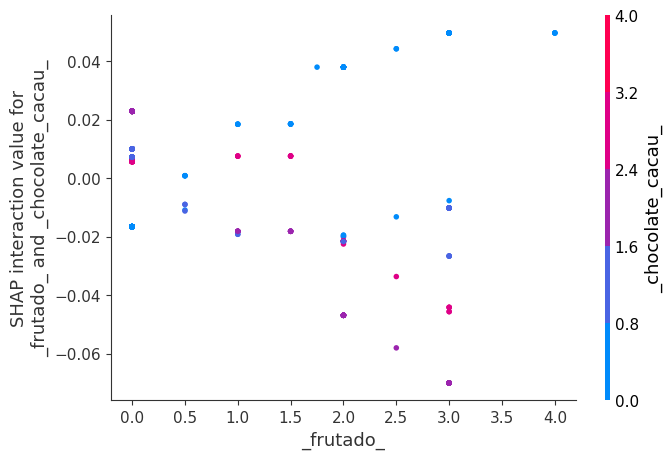

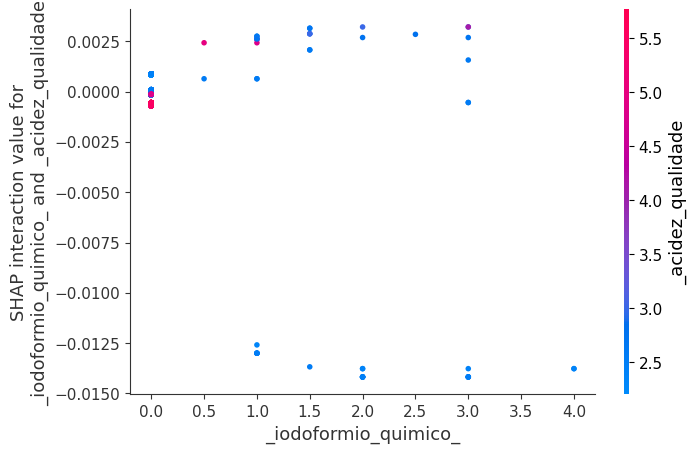

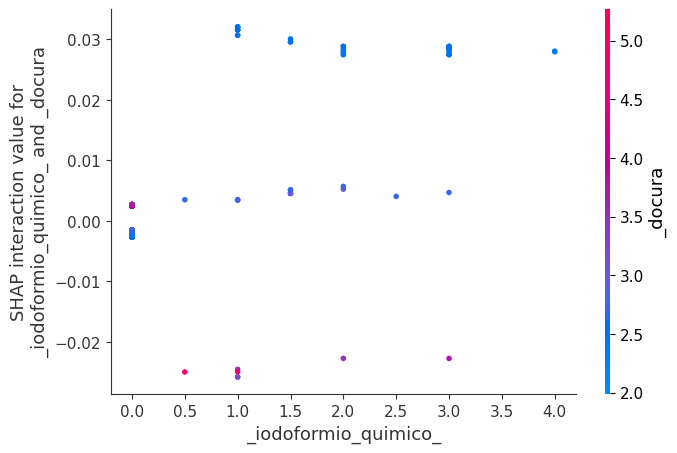

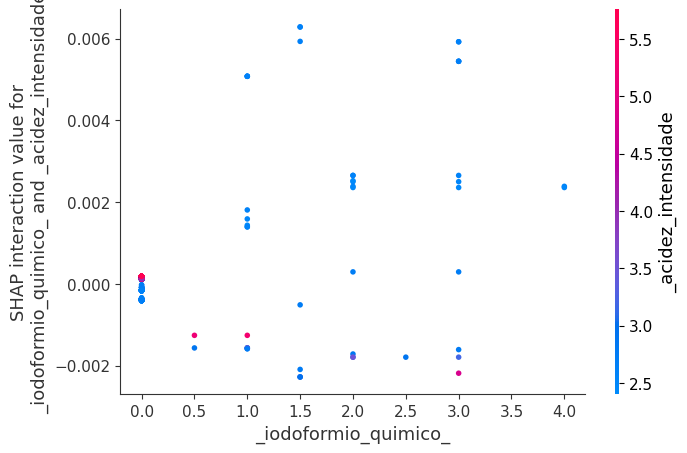

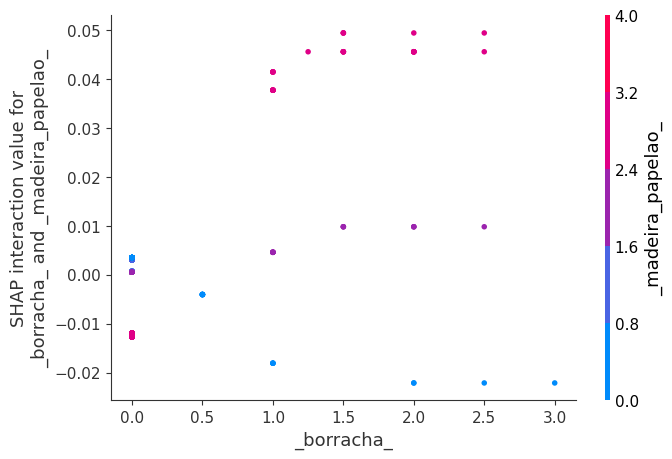

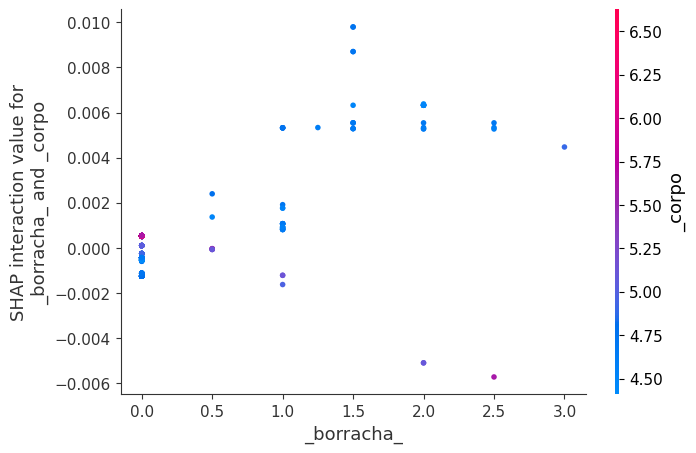

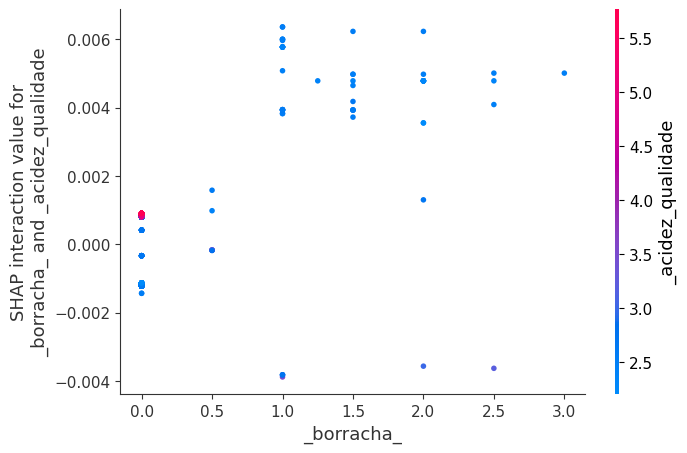

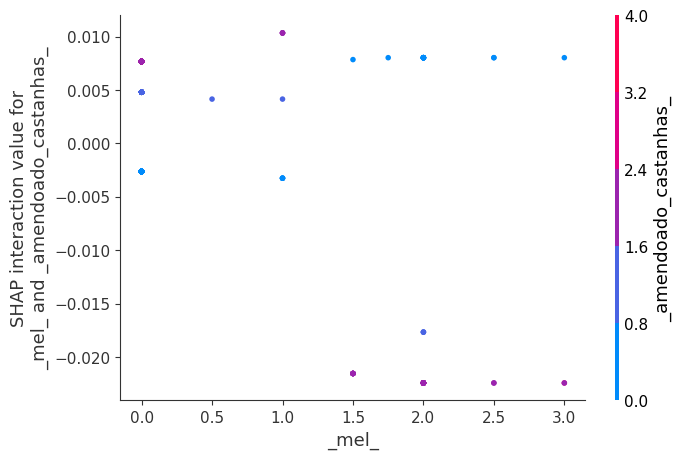

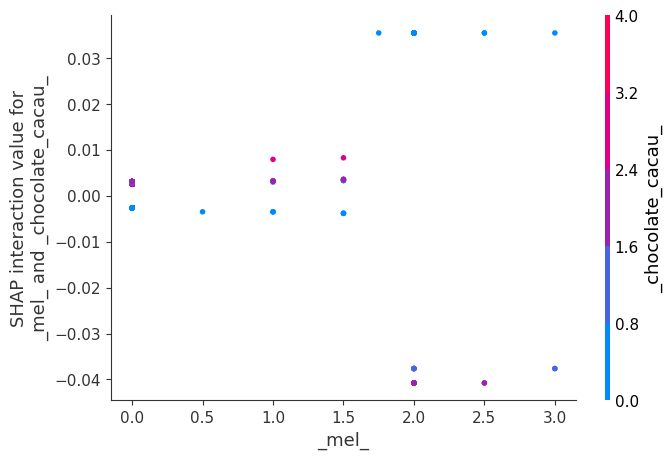

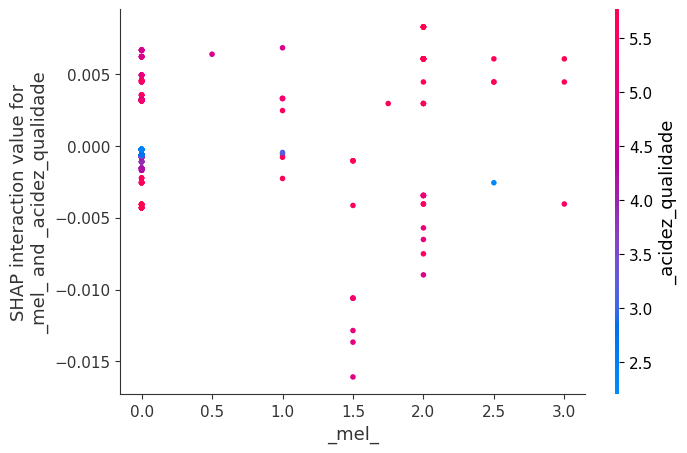

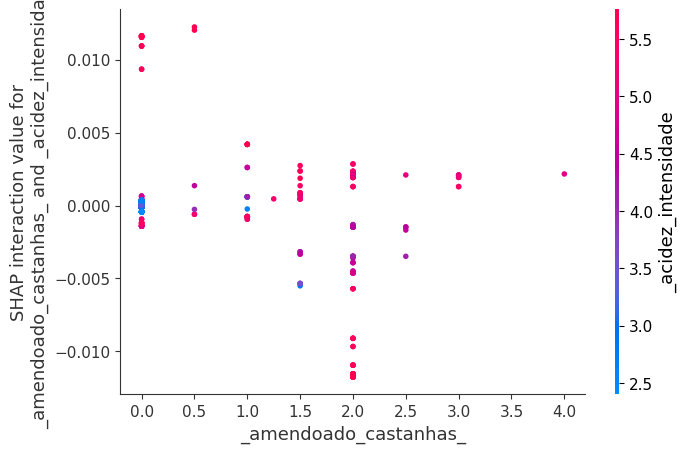

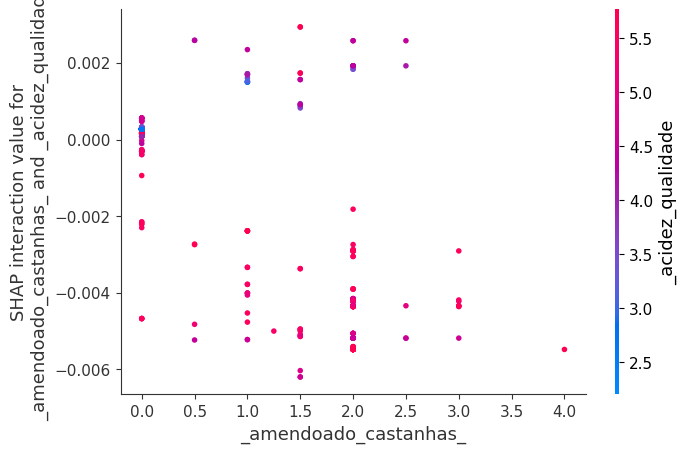

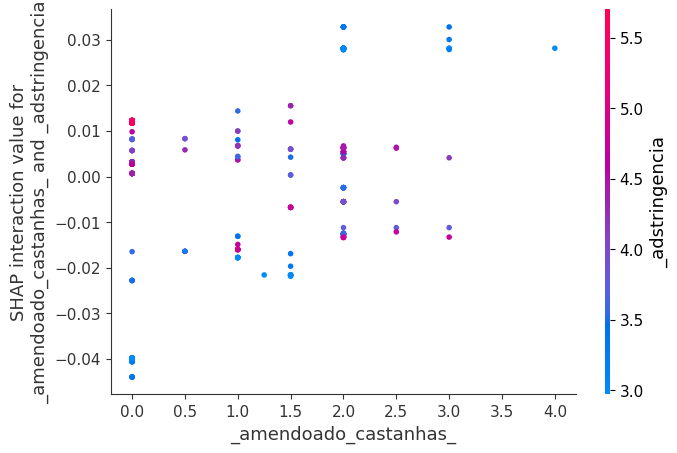

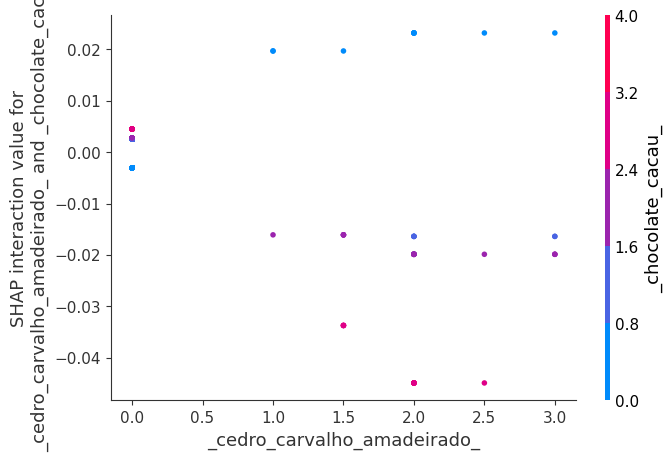

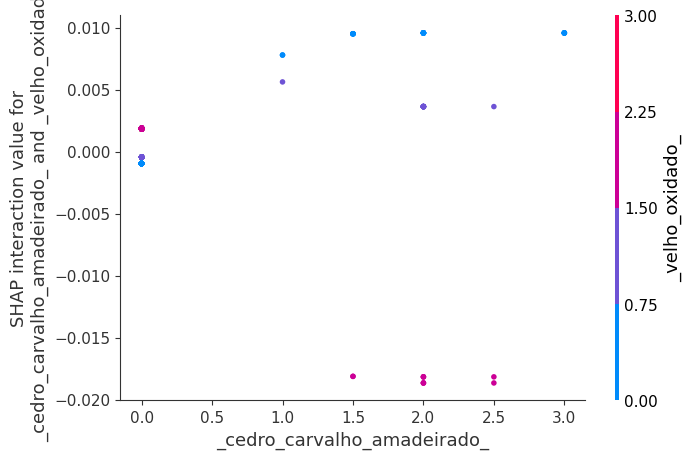

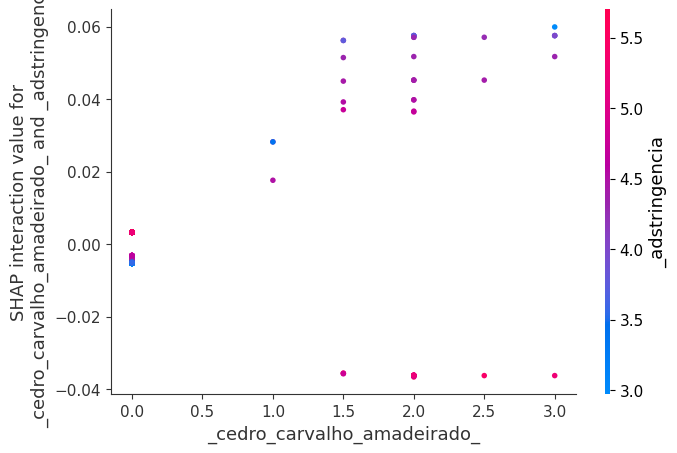

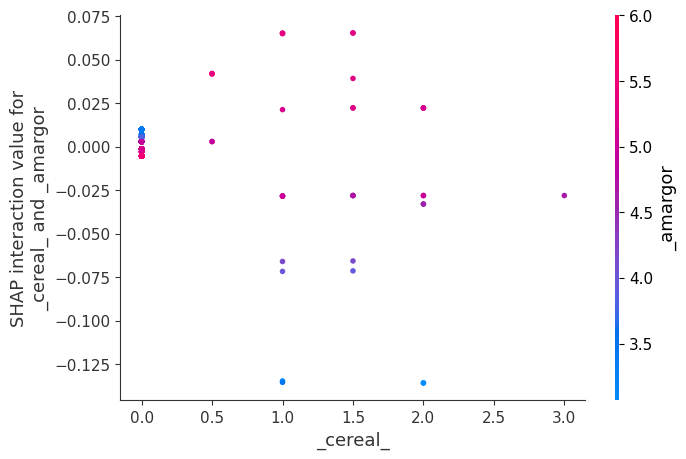

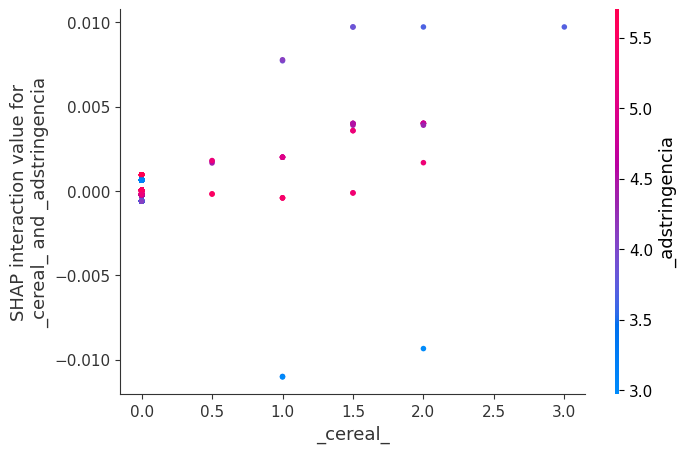

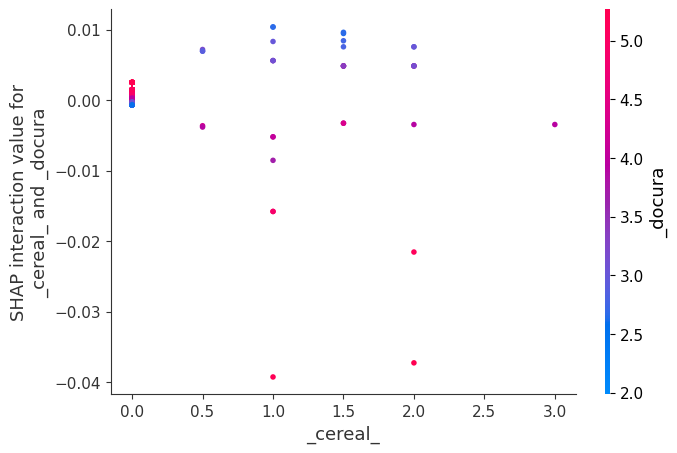

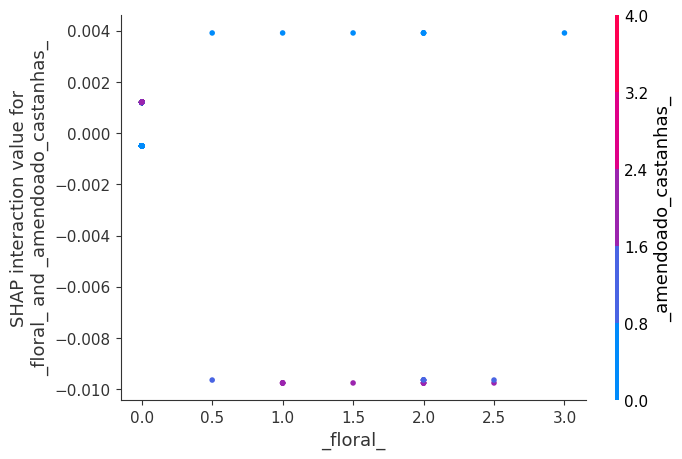

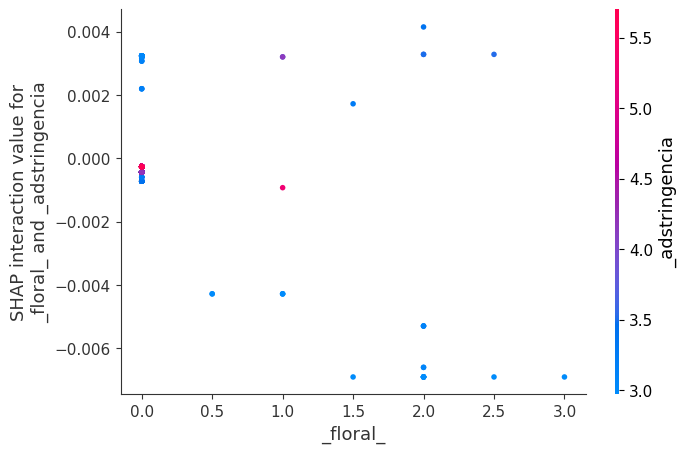

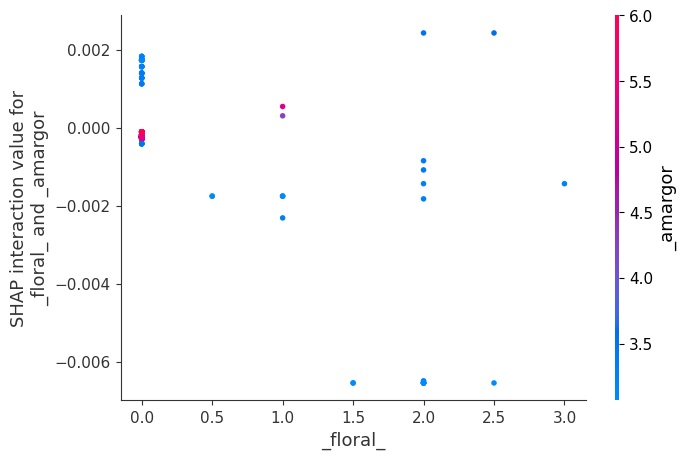

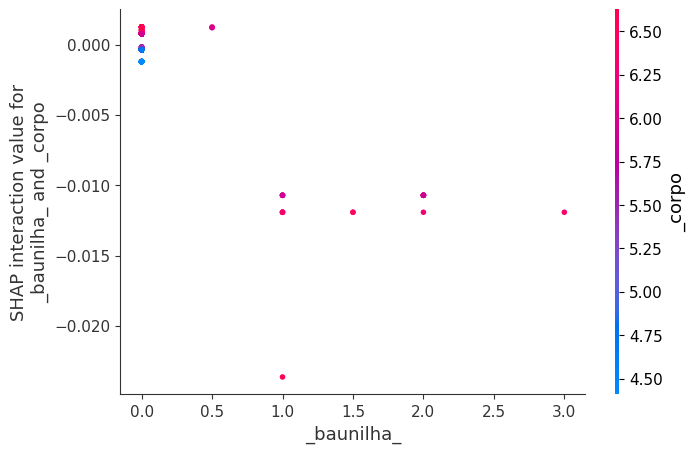

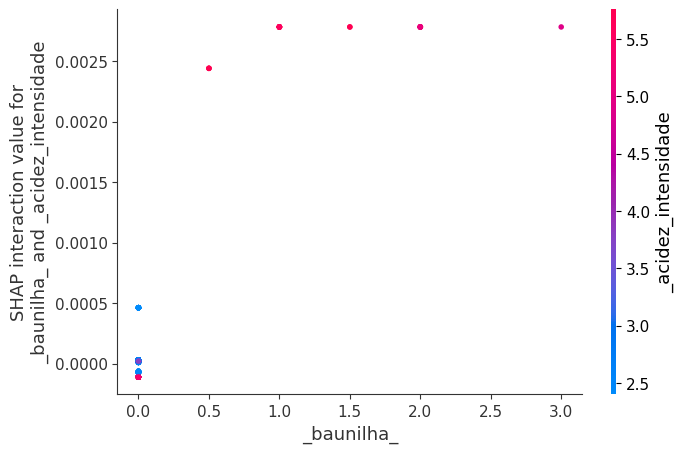

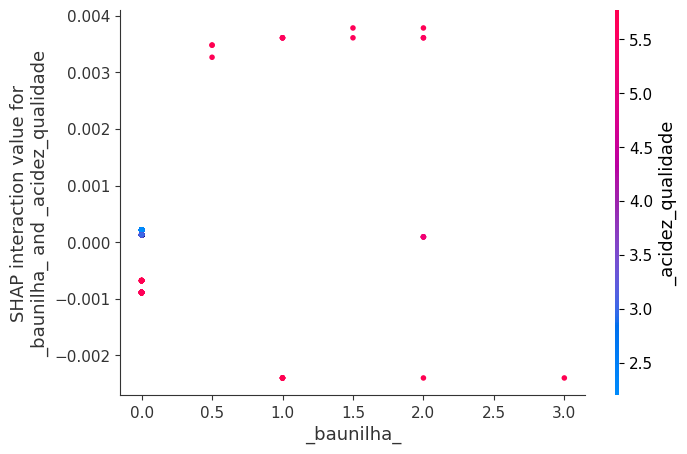

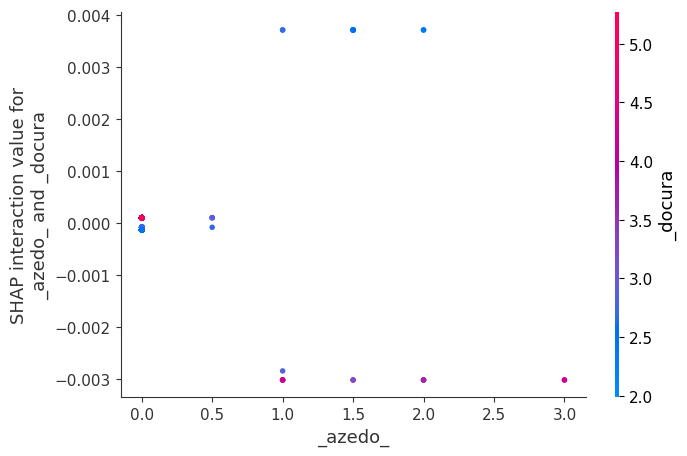

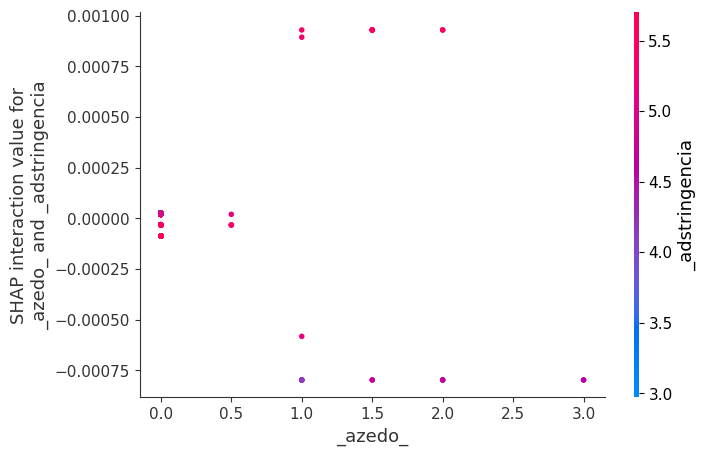

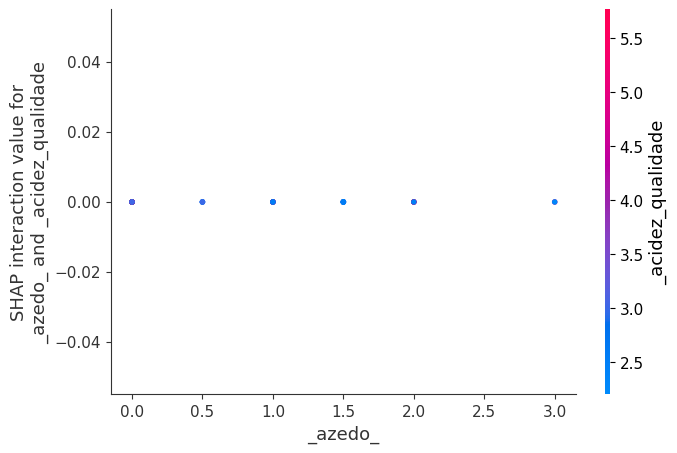

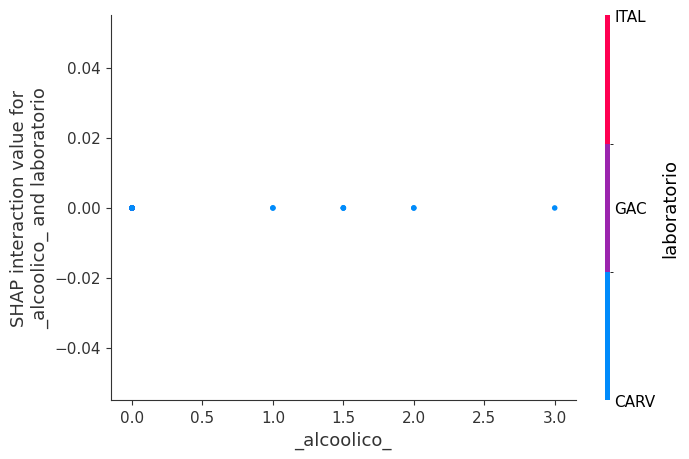

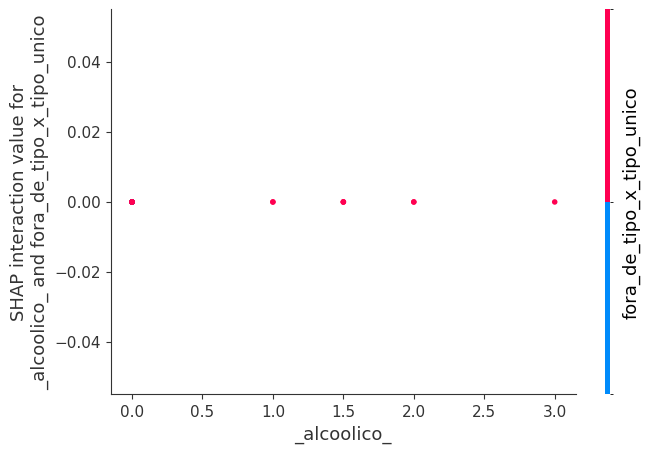

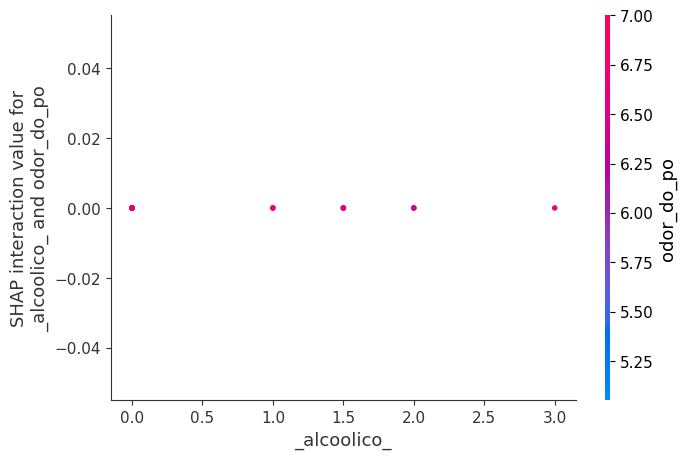

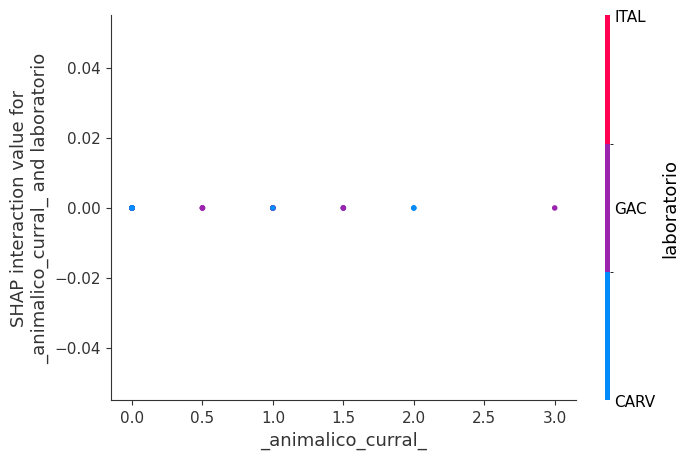

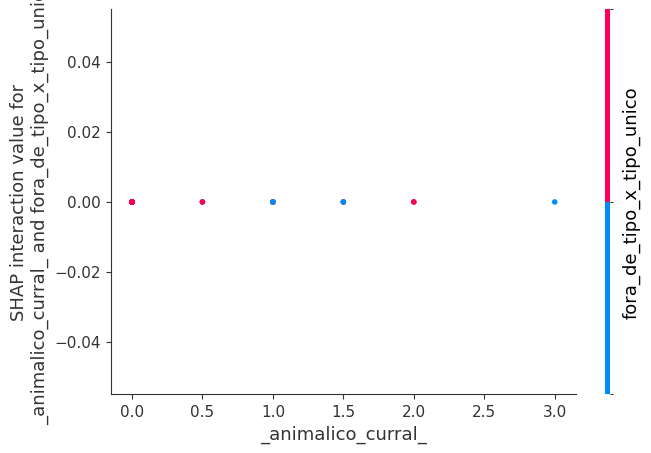

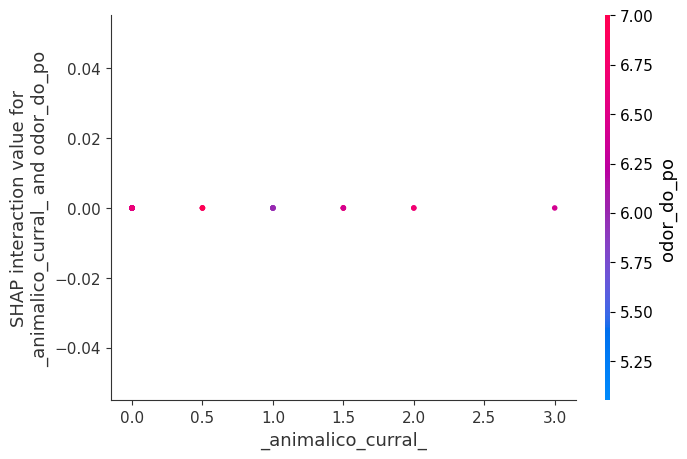

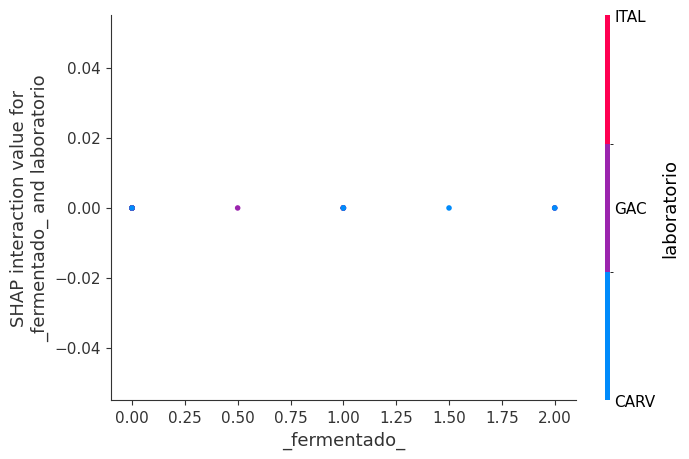

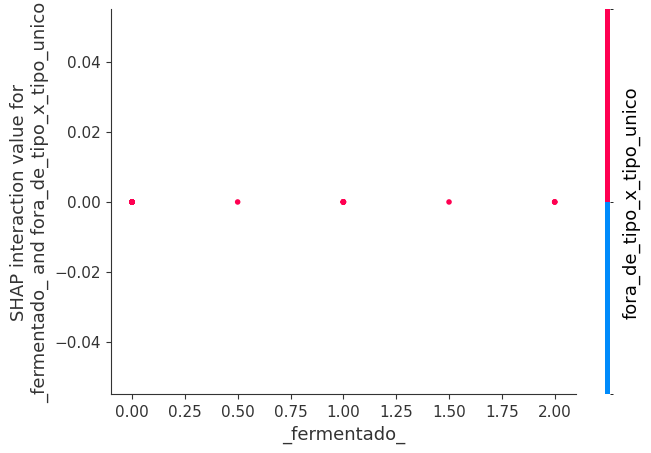

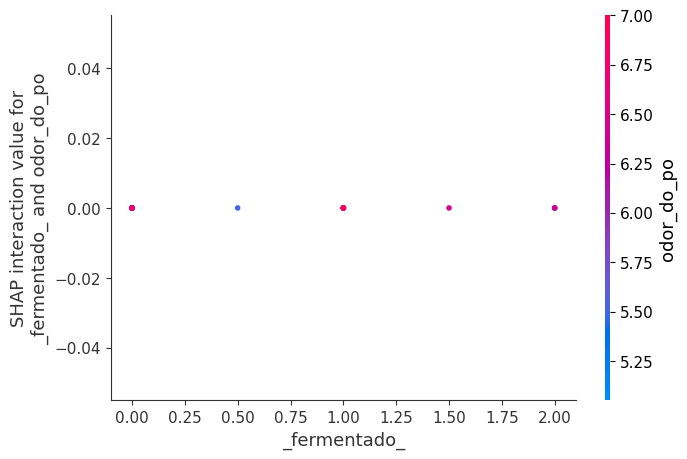

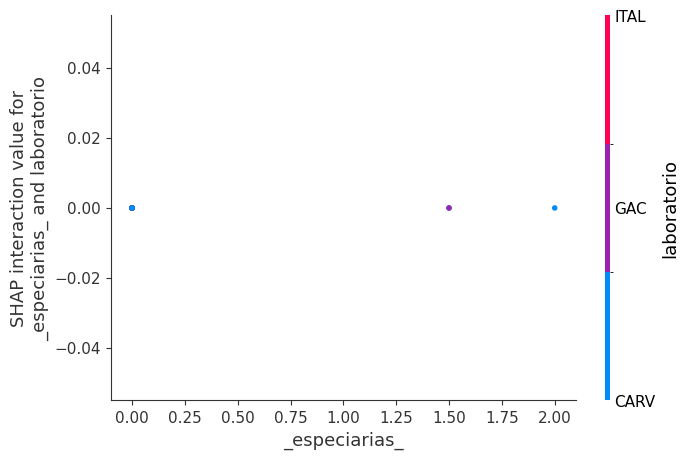

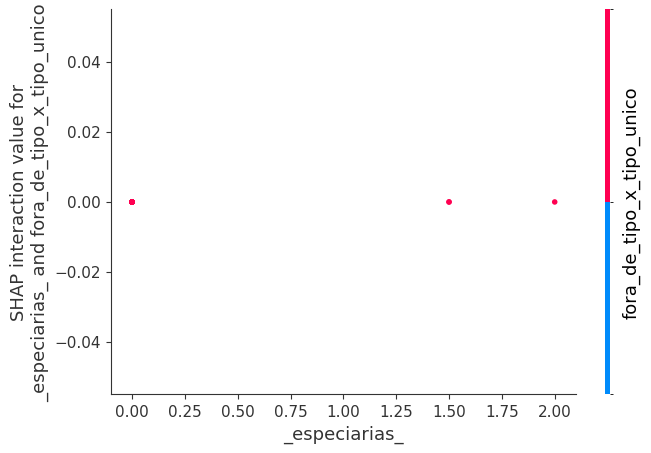

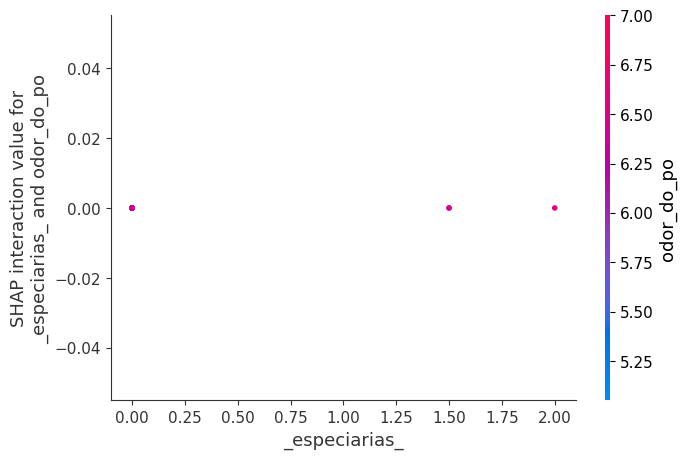

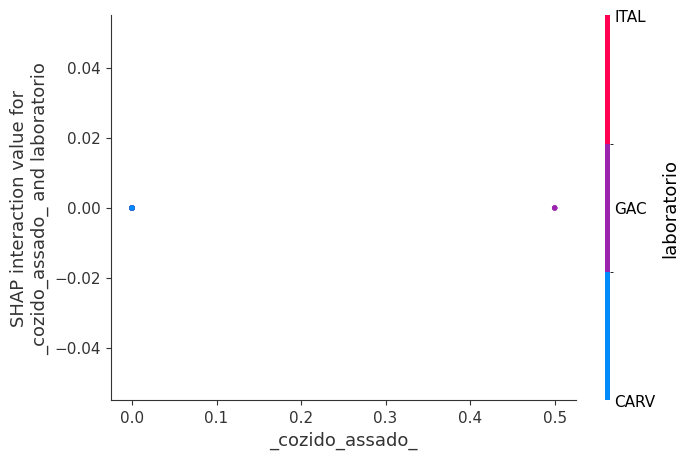

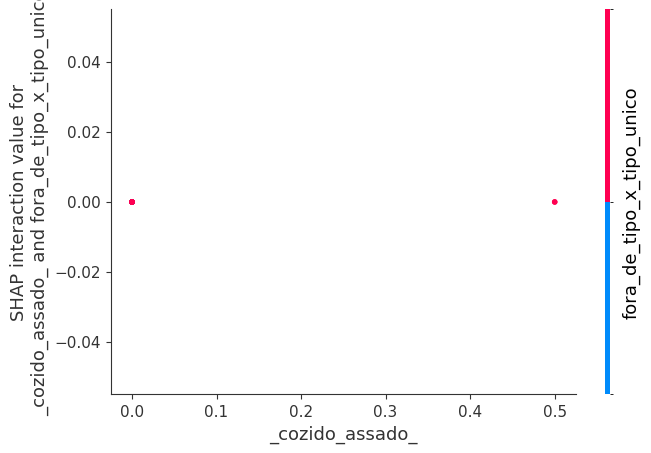

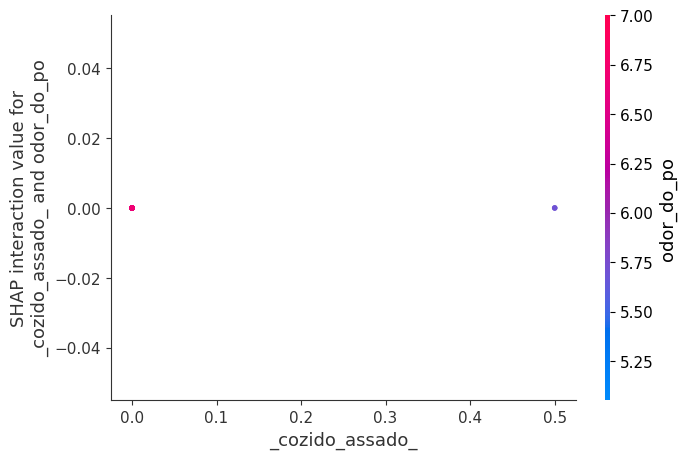

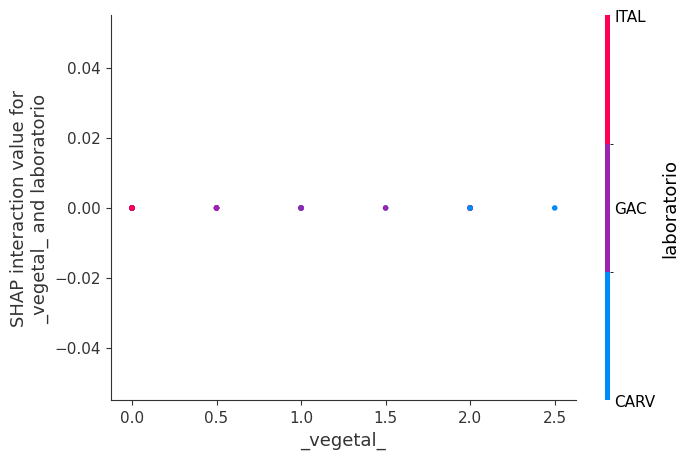

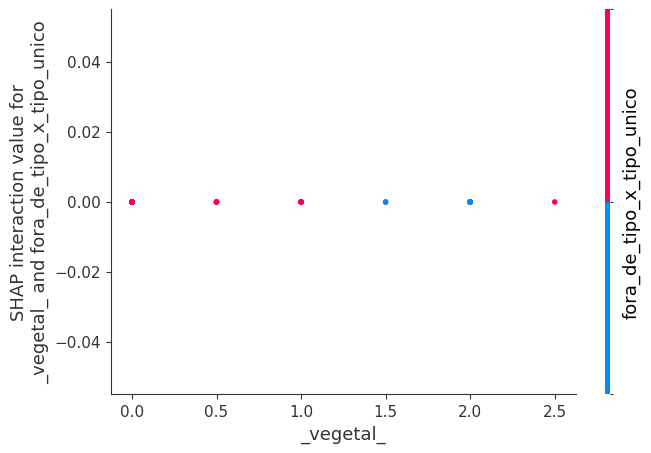

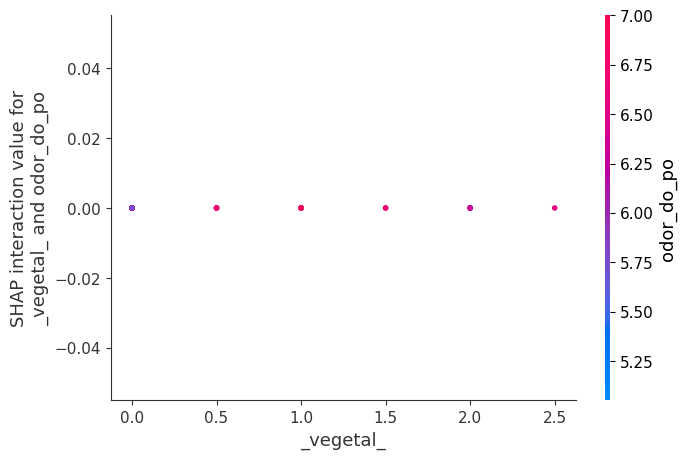

In [121]:


for col in int_imp.index.values:
   for i in range(3):
      index = int_order[col][i]
      int_var = trn_data.columns[index]
      
      shap.dependence_plot((col,int_var) , shap_interaction_values, trn_data)

In [122]:
int_var

'odor_do_po'

In [123]:
shap_vals

array([[ 0.00174014, -0.09869694,  0.0440264 , ...,  0.        ,
        -0.00457549,  0.01163746],
       [ 0.02365035, -0.12201558, -0.03481277, ...,  0.        ,
        -0.02702857,  0.0098209 ],
       [ 0.04326505,  0.00481022, -0.10006386, ...,  0.        ,
        -0.00024906,  0.0200072 ],
       ...,
       [-0.0142292 ,  0.00155073, -0.00253122, ...,  0.        ,
        -0.01574432,  0.00091956],
       [-0.00813203,  0.00121378,  0.04262269, ...,  0.        ,
        -0.01655134, -0.00341858],
       [-0.00687102,  0.00163665,  0.00771871, ...,  0.        ,
        -0.01919791, -0.00133637]])